This notebook contains the workflow for processing iMet-XQ2 data from the stacked drone flights during the NSF BACS-I and BACS-II campaigns. 

Last edited: 9 June 2025

The workflow consists of three steps:
1. Read manual flight logs from BACS and select only the stacked drone flights.
2. Identify the "in-stack" portion of flight from manual flight logs and iMet-XQ2 GPS data.
3. Quality control of iMet-XQ2 meteorological data, which is then written out as a series of netcdf files.

Inputs:
1. BACS drone logs (xlsx)
2. raw iMet-XQ2 data (csv)

Outputs:
1. BACS drone met stack data (netcdf)

For more details about the output files, see the documentation in 'README_BACS_Drone_Met_Stack.pdf'.

For questions, contact: Gabrielle Leung (gabrielle.leung@colostate.edu).

# Imports and Paths

## Shared Libraries

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import datetime as dt
import itertools
import glob
import xarray as xr
import metpy.calc as mpcalc
import metpy.units as units

## Plotting Parameters

In [4]:
# Bee's default plotting parameters
# These are not strictly necessary for the rest of the code.

from palettable.cartocolors.qualitative import Prism_8

prism = Prism_8.mpl_colors
blue = prism[1]
green = prism[3]
purple = prism[0]
red = prism[7]
orange = prism[6]
yellow = prism[5]
gray = "#303039"
style = "/Users/gleung/OneDrive/06_Resources/06.03_matplotlib_styles/bee-paperlight.mplstyle"
plt.style.use(style)

col = [green, blue, purple]

## Define paths

In [5]:
# defining paths
# If you are rerunning/reprocessing these data, you will need to change these to your local machine.

dataPath = "/Users/gleung/Downloads/bacs-drone-qc/"
figPath = (
    "/Users/gleung/Downloads/bacs-drone-qc/figures/"
)

# Shared Functions

In [6]:
drone_log_cols = [
    "flight_id",
    "iop_date_local",
    "iop",
    "drone_name",
    "flight_number_of_day",
    "nominal_altitude",
    "takeoff_time_local",
    "landing_time_local",
    "takeoff_time_utc",
    "landing_time_utc",
    "sensor_aspirated",
    "sensor_unaspirated",
]

In [7]:
imet_raw_data_cols = [
    "XQ-iMet-XQ Pressure",
    "XQ-iMet-XQ Air Temperature",
    "XQ-iMet-XQ Humidity",
    "XQ-iMet-XQ Humidity Temp",
    "XQ-iMet-XQ Date",
    "XQ-iMet-XQ Time",
    "XQ-iMet-XQ Longitude",
    "XQ-iMet-XQ Latitude",
    "XQ-iMet-XQ Altitude",
    "XQ-iMet-XQ Sat Count",
]

imet_data_cols = [
    "pressure",
    "temperature",
    "rh",
    "temperature_from_rh_sensor",
    "date",
    "time",
    "longitude",
    "latitude",
    "altitude_msl",
    "satellite_count",
]

In [8]:
def clean_imet_data(
    path, imetCols=imet_raw_data_cols, imetnewCols=imet_data_cols
):
    # this function reads the data from the raw iMet files and cleans it up

    df = pd.read_csv(path, parse_dates=True)
    df = df[imetCols]
    df.columns = imetnewCols

    # iMet gives bad dates when GPS is not working, so get rid of those
    df = df[(df.date.str[:4] == "2023") | (df.date.str[:4] == "2022")]
    df = df[df.date.str[8:10] != "00"]

    # only want to use data when GPS has at least four satellites in view
    df = df[df.satellite_count >= 4]

    df["datetime_utc"] = pd.to_datetime(df.date + " " + df.time)
    df["datetime_local"] = df.datetime_utc - dt.timedelta(hours=6)

    return df

In [9]:
def split_consecutive_groups(lst):
    # this is a function to split list into groups of consecutive repeated values
    return [list(group) for key, group in itertools.groupby(lst)]

# Manual drone logs

In [ ]:
# First, we need to standardize and concatenate the drone flight logs from BACS-I and BACS-II.

logs = []

for ver in ["bacs-i", "bacs-ii"]:
    # This is the  manual flight log
    log = pd.read_excel(f"{dataPath}/{ver}-log.xlsx", parse_dates=True)

    # renaming columns in manual flight log
    log = log.rename(
        columns={
            "Date ": "iop_date_local",
            "Drone": "drone_name",
            "IOP": "iop",
            "Flight Number": "flight_number_of_day",
            "Drone Altitude (m)": "nominal_altitude",
            "Takeoff TIme": "takeoff_time_local",
            "Landing Time": "landing_time_local",
            "iMet (Aspirated)": "sensor_aspirated",
            "iMet (Unaspirated) Name": "sensor_unaspirated",
        }
    )

    # Delete the other variables in the drone log, these are notes and not needed for the data upload
    log = log[[c for c in drone_log_cols if c in log.columns]]

    # exclude PJ since that was always the profiler drone and we only want stacked flights
    log = log[log.drone_name.str.lower() != "pj"]

    # exclude any flights where drone was profiling
    log = log[~((log.nominal_altitude.astype("str").str).contains("Prof"))]

    # exclude 2 flights that were marked as "bad" -- aborted flights because of issues with SASS drone
    log = log[~((log.nominal_altitude.astype("str").str).contains("bad"))]

    # get takeoff/landing times in standard format
    for var in ["takeoff_time_local", "landing_time_local"]:
        log[var] = [
            dt.datetime.combine(d.date(), t)
            for d, t in zip(log.iop_date_local, log[var])
        ]

        # all the flights were done in late morning to evening period local time,
        # so just convert everything to 24-hr time appropriately
        log.loc[log[~log[var].dt.hour.isin([10, 11, 12])].index, var] = log[
            ~log[var].dt.hour.isin([10, 11, 12])
        ][var] + dt.timedelta(hours=12)

        # convert local time to UTC
        log[f"{var.rstrip('_local')}_utc"] = log[var] + dt.timedelta(hours=6)

    # print out how many individual flights were in each campaign
    print(
        ver,
        len(
            log.groupby(["iop", "flight_number_of_day"])
            .drone_name.count()
            .index
        ),
    )

    logs.append(log)

logs = pd.concat(logs).reset_index(drop=True)

# We are missing data from last day (TOFIX)
logs = logs[logs.iop < 28]

# standardize drone names (this doesn't matter, just for my sanity)
logs["drone_name"] = logs.drone_name.replace(
    {"Altocumulus": "Ac", "Cumulonimbus": "Cb", "Stratus": "St"}
)

print(
    "Total number of flights: ",
    len(logs.groupby(["iop", "flight_number_of_day"]
                     ).drone_name.count().index),
)

bacs-i 48
bacs-ii 53
Total number of flights:  99


In [22]:
# Want to give each flight over the whole campaign a unique flight ID from 01 to 99

flts = (
    logs.groupby(["iop", "flight_number_of_day"])
    .first()[["iop_date_local"]]
    .reset_index()
)
flts["flight_id"] = np.arange(1, len(flts) + 1).astype("str")
flts["flight_id"] = flts.flight_id.str.zfill(2)

print(flts)

logs = logs.merge(
    flts[["flight_id", "iop_date_local", "flight_number_of_day"]]
)[drone_log_cols]

# save this temporary flight log with takeoff and landing times
logs.to_csv(f"{dataPath}/stack_manual_flightlog.csv")

    iop  flight_number_of_day iop_date_local flight_id
0     1                     1     2022-05-24        01
1     1                     2     2022-05-24        02
2     1                     3     2022-05-24        03
3     2                     1     2022-05-27        04
4     2                     2     2022-05-27        05
..  ...                   ...            ...       ...
94   26                     4     2023-06-17        95
95   26                     5     2023-06-17        96
96   26                     6     2023-06-17        97
97   27                     1     2023-06-21        98
98   27                     2     2023-06-21        99

[99 rows x 4 columns]


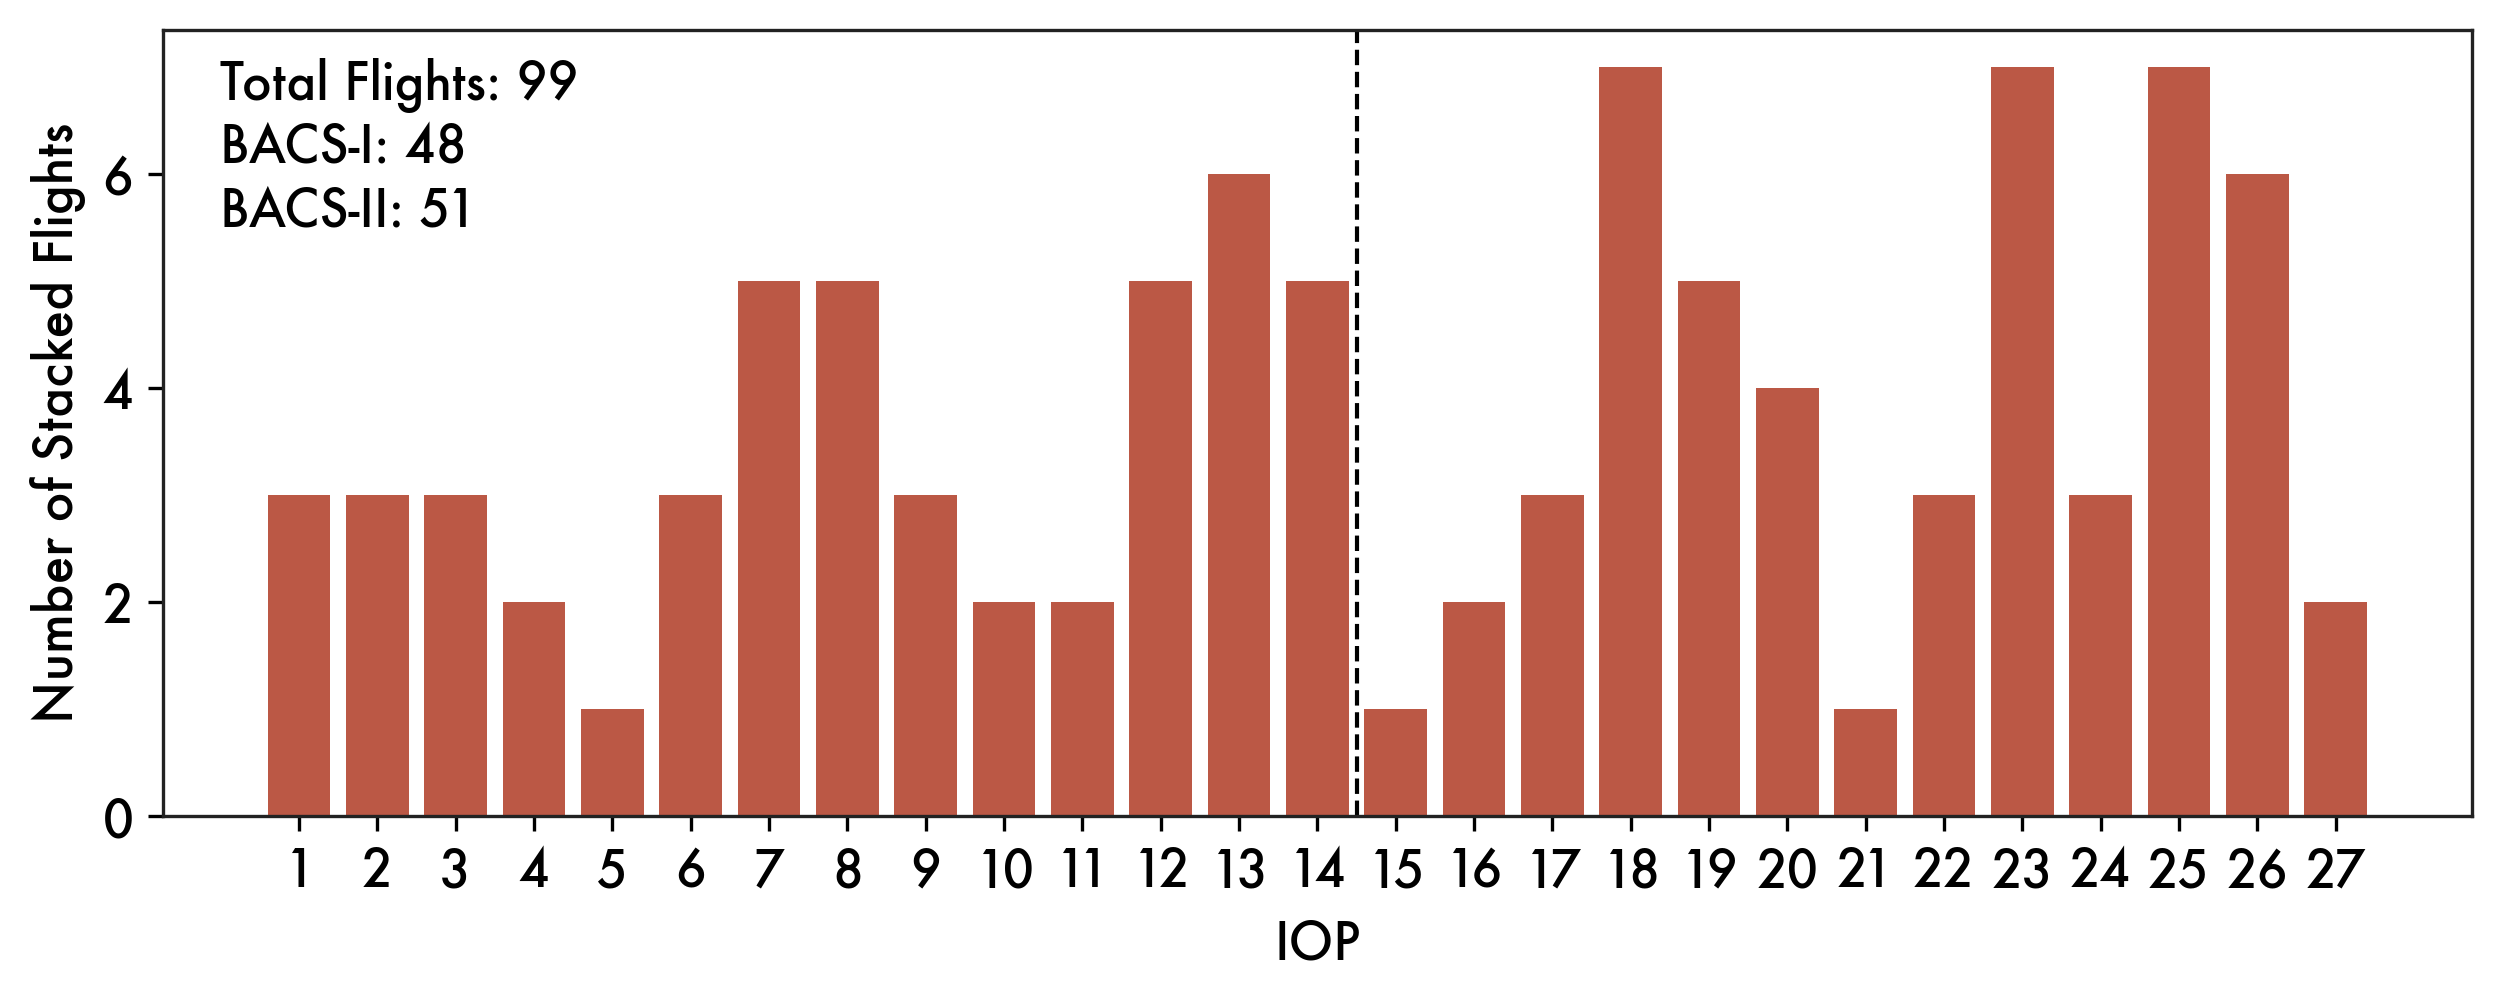

In [ ]:
fig, ax = plt.subplots(1, 1, figsize=(8.5, 3.5))

ax.bar(logs.iop.unique(), logs.groupby("iop").flight_id.nunique())
ax.set_xlabel("IOP")
ax.set_ylabel("Number of Stacked Flights")
ax.axvline(14.5, lw=1, zorder=0, ls="--")
ax.set_xticks(logs.iop.unique())

plt.text(
    0.025,
    0.75,
    f"Total Flights: {len(logs.flight_id.unique())}\nBACS-I: {len(logs[logs.iop_date_local.dt.year == 2022].flight_id.unique())}\nBACS-II: {len(logs[logs.iop_date_local.dt.year == 2023].flight_id.unique())}",
    transform=ax.transAxes,
)

plt.show()
plt.close("all")

# In-stack drone logs

The manual flight logs only have the takeoff and landing times (BACS-II had an estimate of in-stack time, but I don't trust these are accurate down to the second). We want to make a log that has only the time when drones are in stack.

In [12]:
logs = pd.read_csv(
    f"{dataPath}/stack_manual_flightlog.csv",
    index_col=0,
    parse_dates=[
        "takeoff_time_utc",
        "landing_time_utc",
        "takeoff_time_local",
        "landing_time_local",
        "iop_date_local",
    ],
)
logs["flight_id"] = logs.flight_id.astype("str").str.zfill(2)

## Preliminary things

### Determining ground level

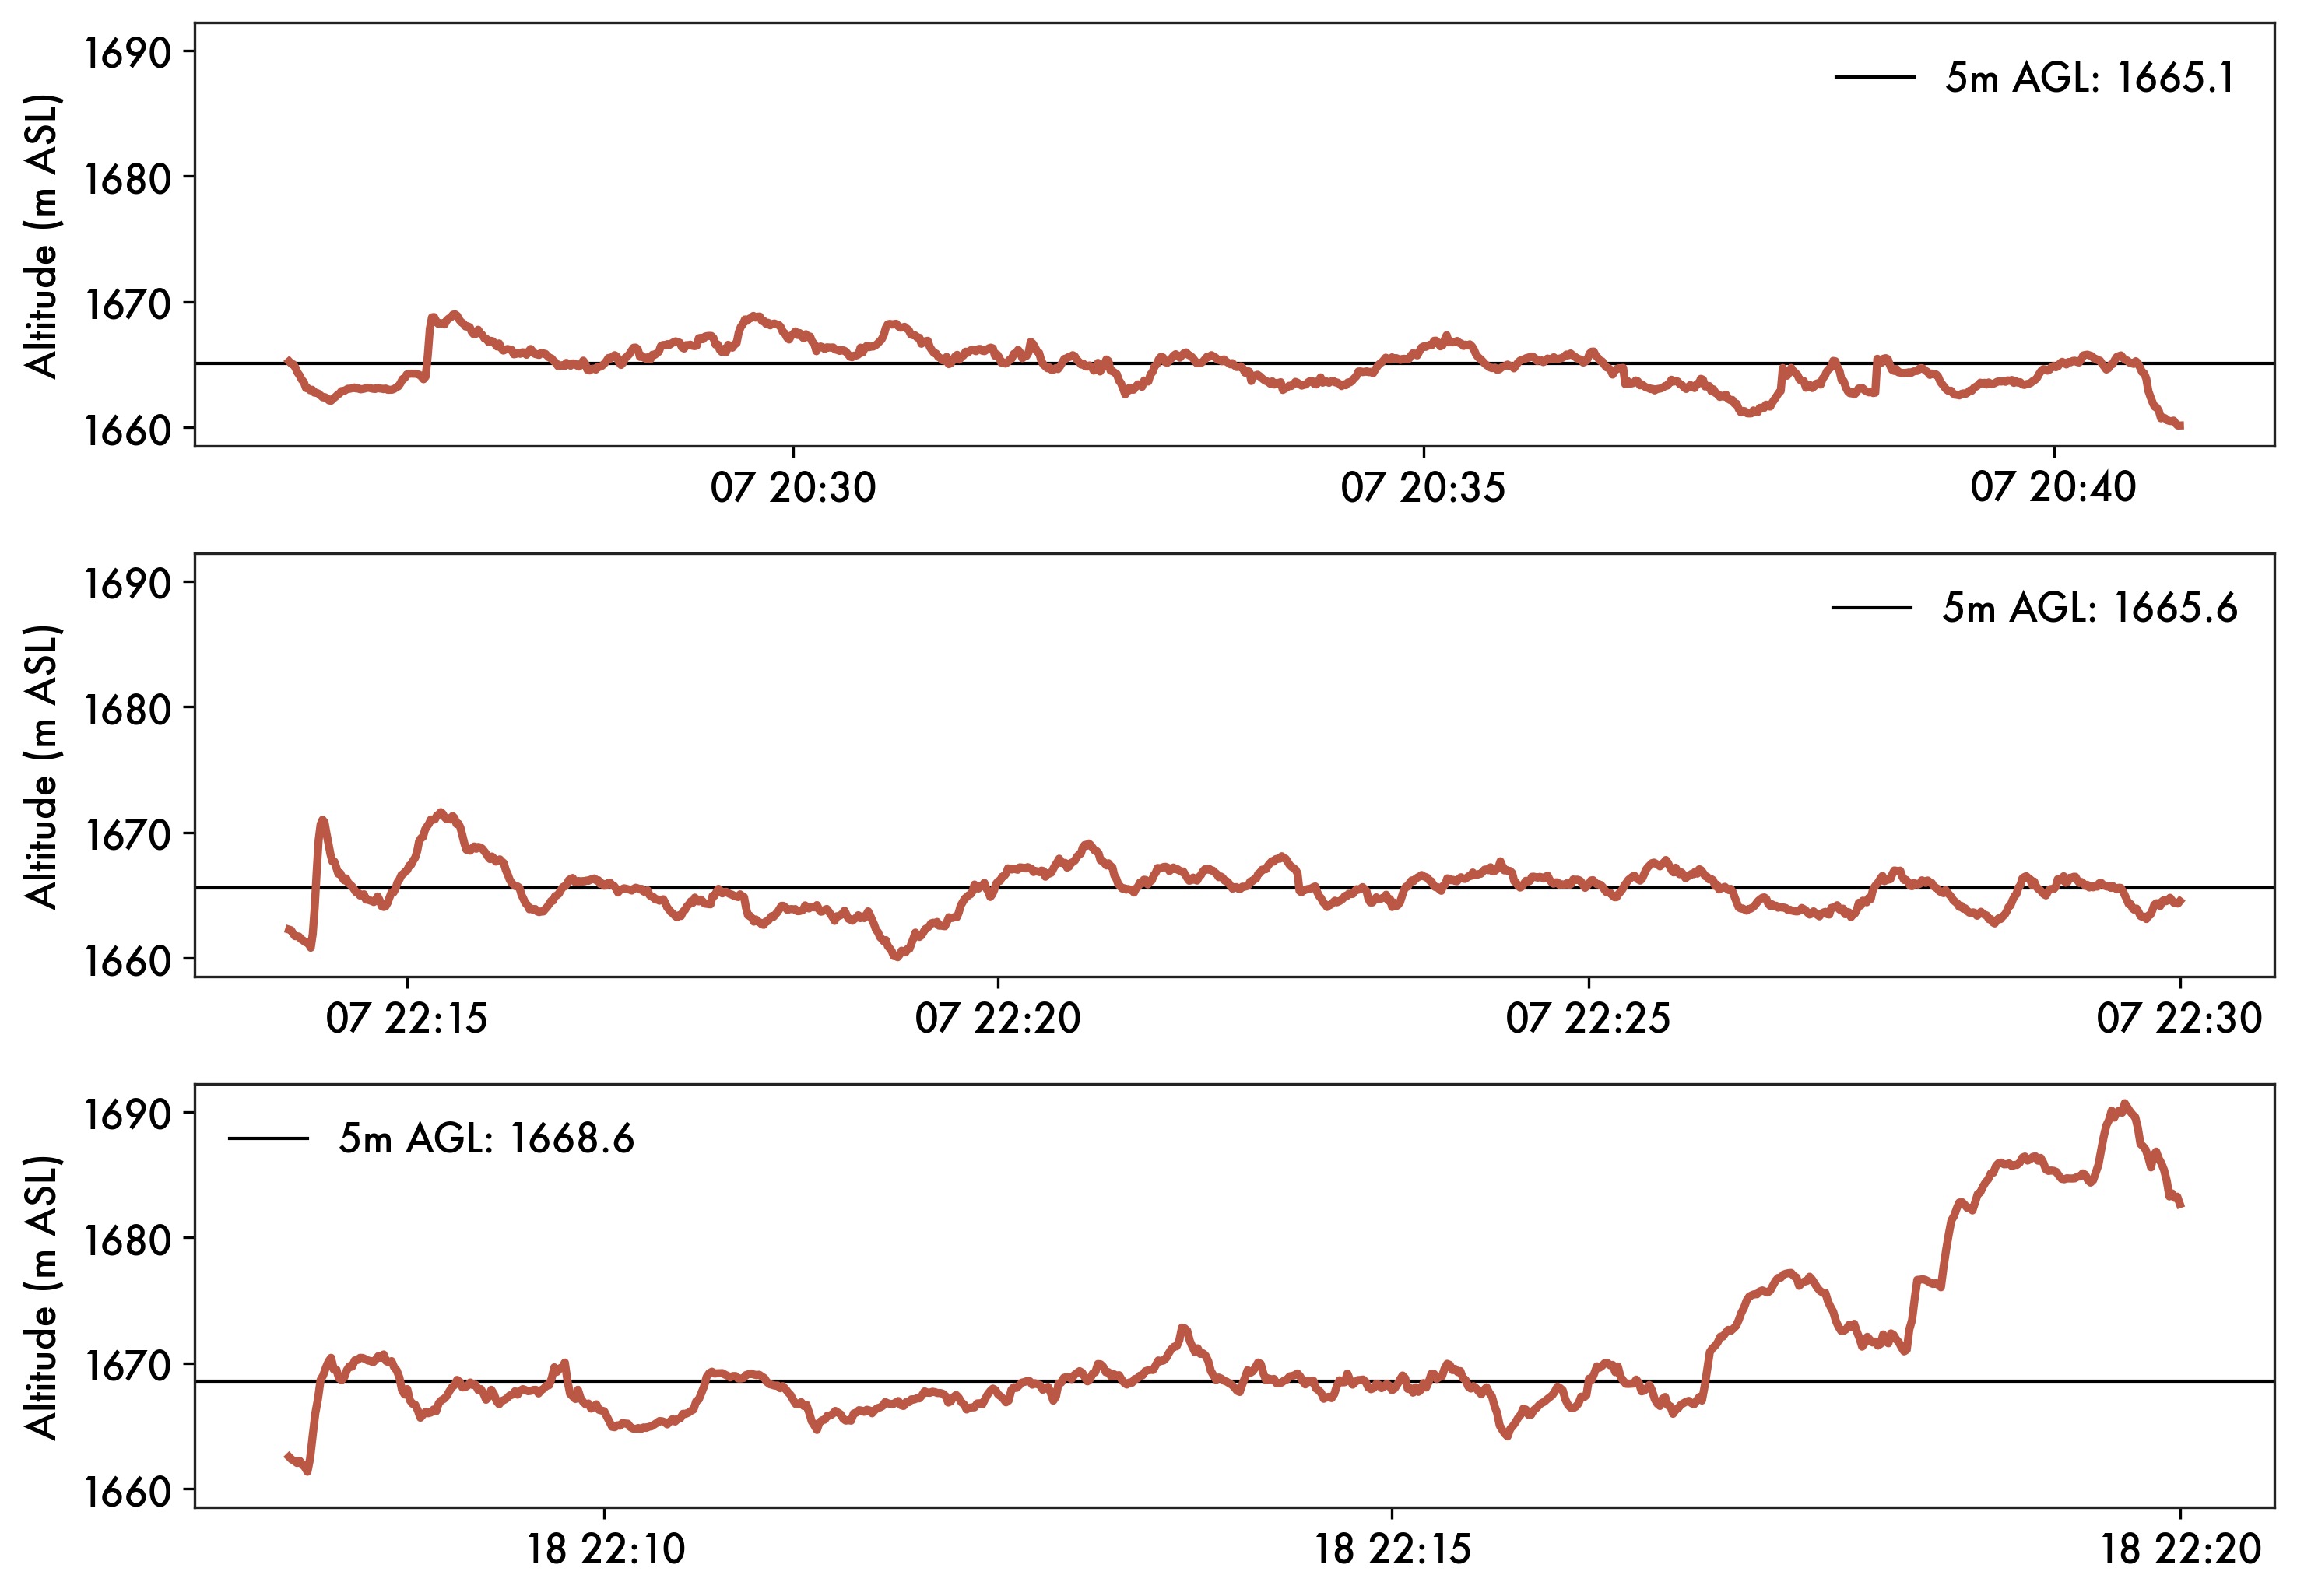

Ground level is 1661.4 m ASL.


In [13]:
# We need to find an accurate height (in m above sea level) to use for ground level

# There were three flights that were nominally supposed to be hovering 5m above the surface station. Let's use these
# three flights to define the ground height above sea level.

nominal_altitude = 5

lowflts = logs[logs.nominal_altitude == nominal_altitude]

ground = []

fig, axes = plt.subplots(len(lowflts), 1, sharey=True)

for ax, (l, log) in zip(axes, lowflts.iterrows()):
    imetPath = f"{dataPath}/raw_data/{log.sensor_aspirated}-{log.iop_date_local.strftime('%Y%m%d')}*.csv"

    # read in raw XQ2 data from iMet CSVs
    # sometimes there is more than one CSV (when we saved data midway through the IOP)
    # so concatenate multiple files if needed
    imetData = pd.concat(
        [clean_imet_data(path) for path in glob.glob(imetPath)]
    ).sort_values("datetime_utc")

    imetData = imetData[
        (imetData.datetime_utc >= log.takeoff_time_utc)
        & (imetData.datetime_utc <= log.landing_time_utc)
    ]

    ground.append(imetData.altitude_msl.median())

    ax.plot(imetData.datetime_utc, imetData.altitude_msl)
    ax.set_ylabel("Altitude (m ASL)")
    ax.axhline(
        imetData.altitude_msl.median(),
        zorder=0,
        lw=1,
        label=f"5m AGL: {imetData.altitude_msl.median():.1f}",
    )
    ax.legend()

plt.show()
plt.close("all")

ground = np.nanmean(ground) - nominal_altitude

print(f"Ground level is {ground:.1f} m ASL.")

### Calculating expected standard deviations

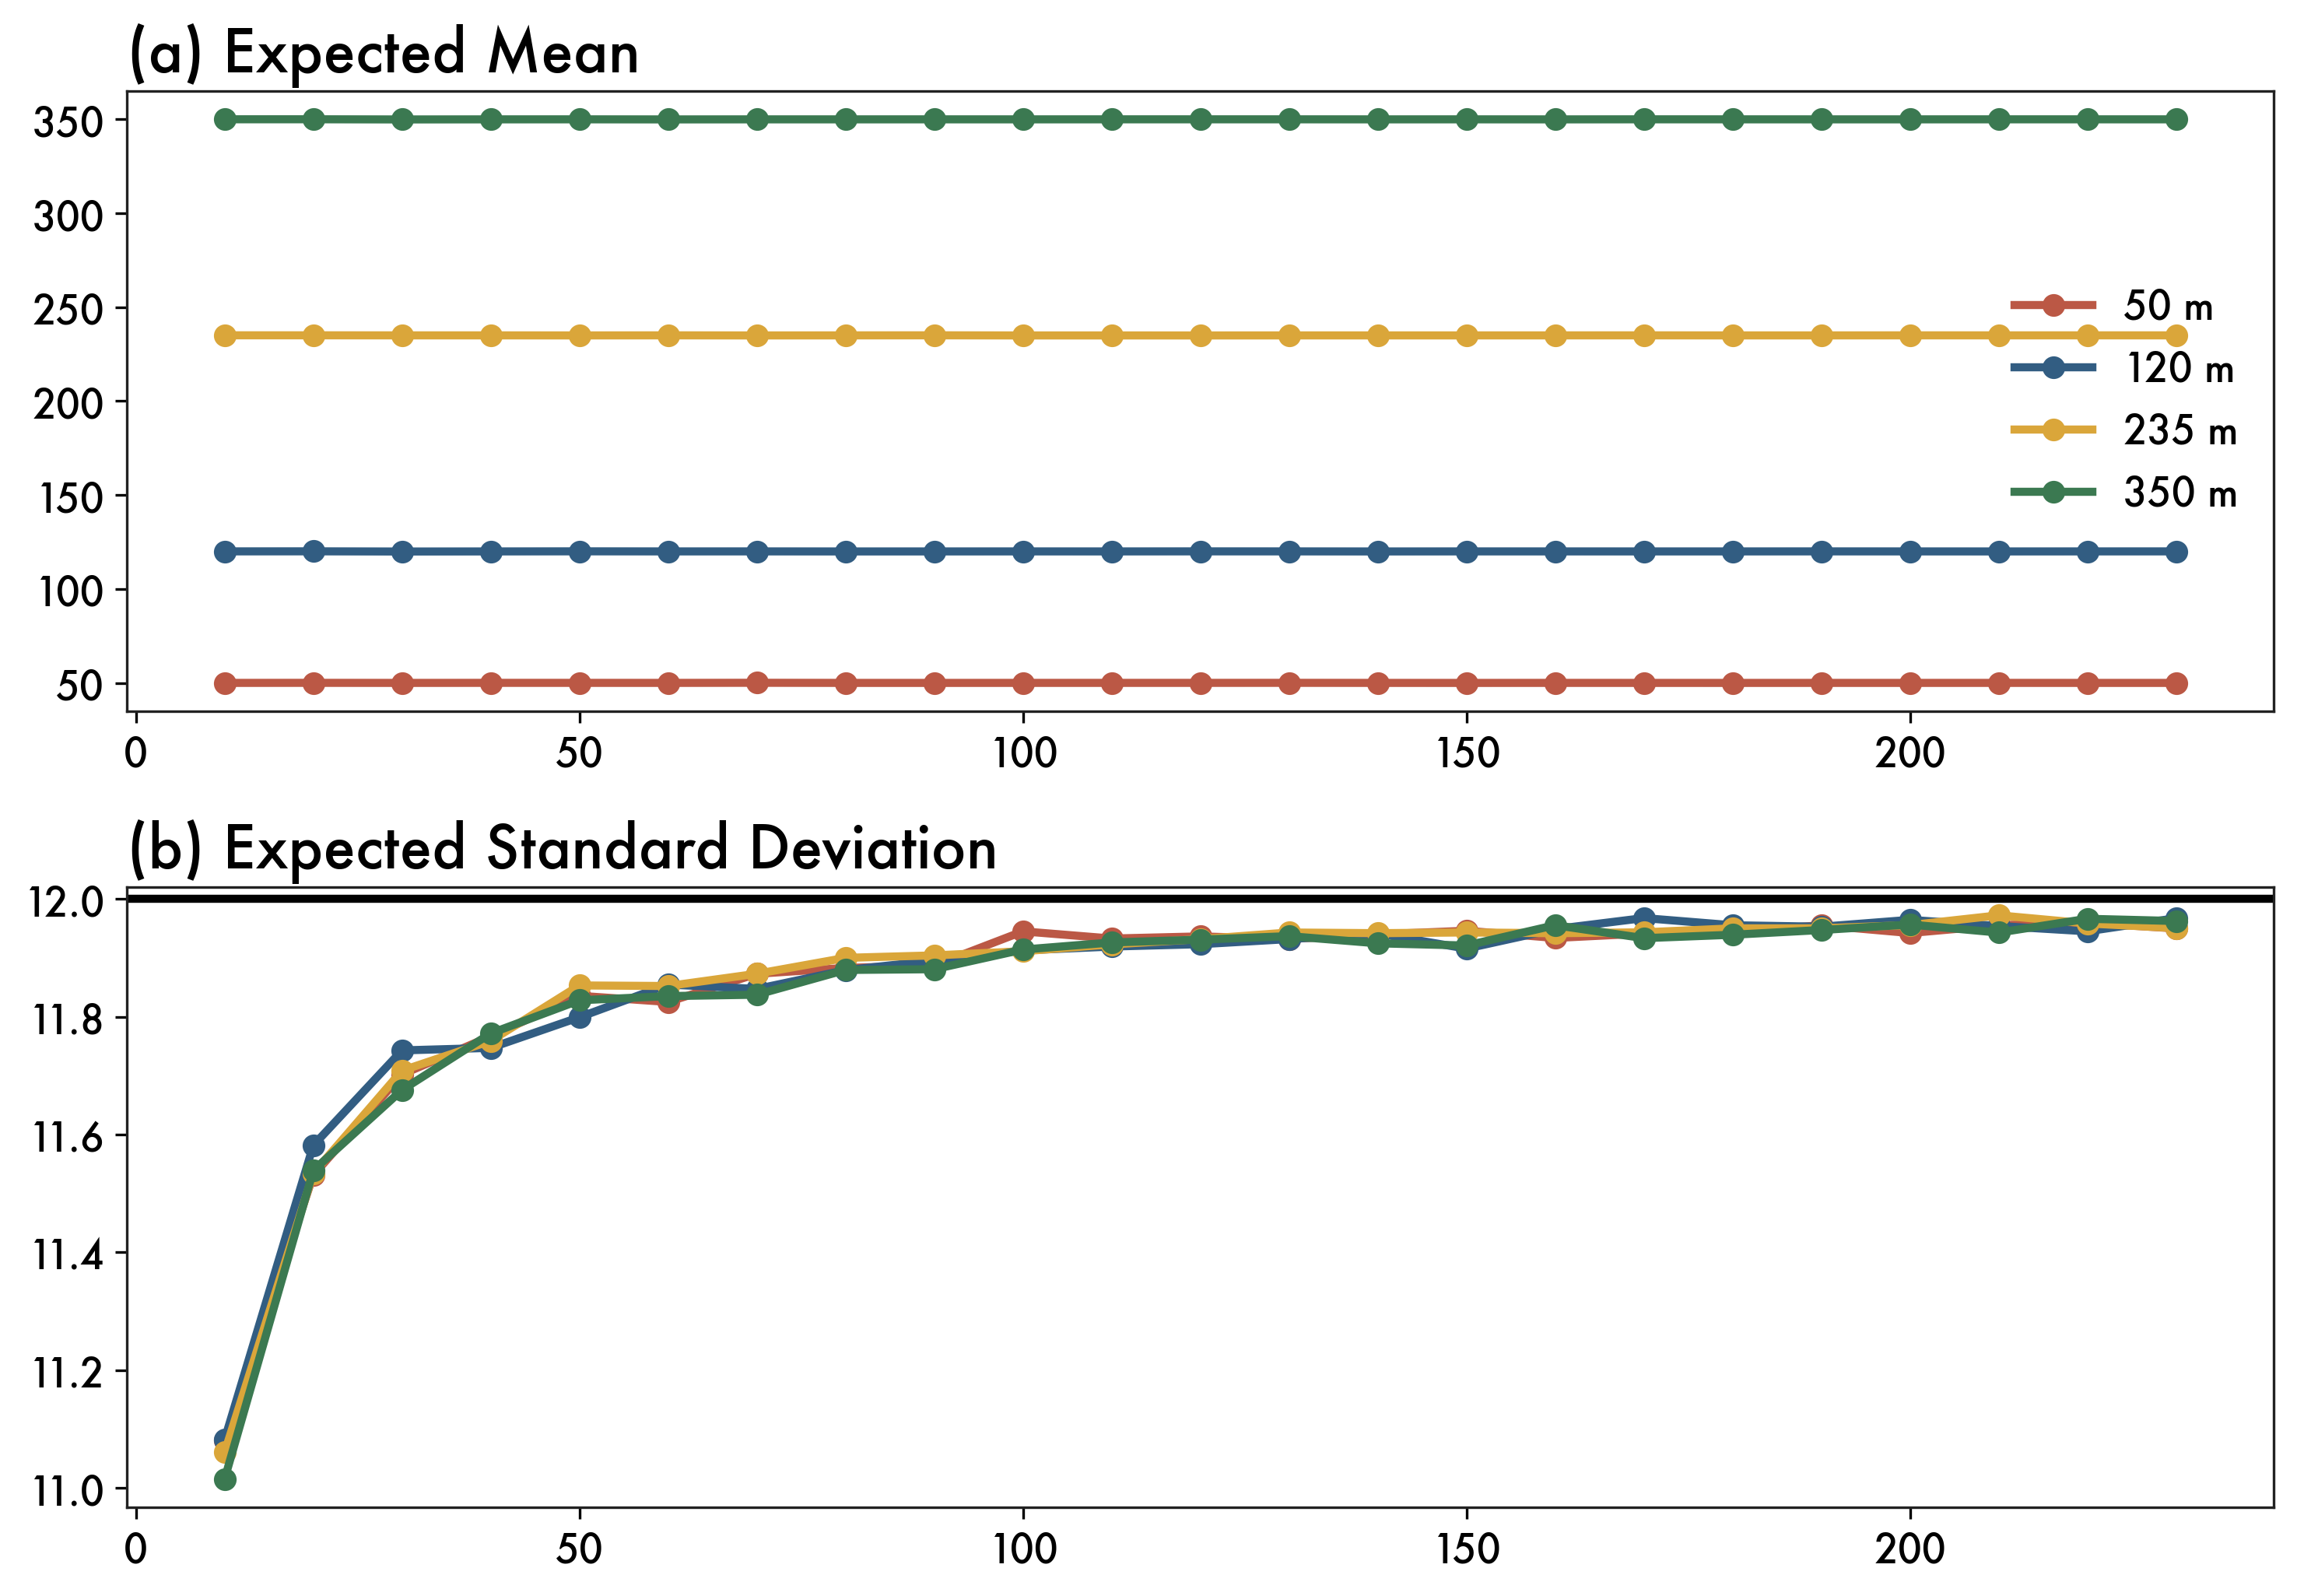

In [14]:
# To determine if the flight is at level leg, I look at the standard deviation of altitude over some time period
# Sanity check: showing that if the error is random gaussian (with reported accuracy), then as the time period gets longer
# the standard deviation should approach the reported accuracy!

fig, axes = plt.subplots(2, 1)

for alt in [50, 120, 235, 350]:
    mns_ = []
    stds_ = []

    for d in np.arange(10, 240, 10):
        mns = []
        stds = []

        for i in range(5000):
            timeseries = []

            for i in range(d):
                timeseries.append((ground + alt) + (np.random.normal() * 12))

            mns.append(np.mean(timeseries) - ground)
            stds.append(np.std(timeseries))

        mns_.append(np.mean(mns))
        stds_.append(np.mean(stds))

    axes[0].plot(np.arange(10, 240, 10), mns_, label=f"{alt} m", marker="o")
    axes[1].plot(np.arange(10, 240, 10), stds_, label=alt, marker="o")

axes[0].legend()
axes[1].axhline(12)

axes[0].set_title("(a) Expected Mean")
axes[1].set_title("(b) Expected Standard Deviation")

plt.show()

## Determining in-stack periods

In [15]:
def plot_instack_determination(
    df,
    flight_id,
    nominal_altitude,
    iop,
    iop_date_local,
    sensor="aspirated",
    ground=ground,
):
    # create plots to sanity check whether correct timeperiod is being flagged as in stack

    fig, axes = plt.subplots(4, 1, sharex=True, figsize=(6, 12))

    for ax, var, title, units, accuracy in zip(
        axes,
        ["temperature", "altitude_msl", "latitude", "longitude"],
        ["(a) Temperature", "(b) Altitude", "(c) Latitude", "(d) Longitude"],
        ["$^\circ$C", "m (ASL)", "$^\circ$ N-S", "$^\circ$ E-W"],
        [None, 12, 8e-5, 8e-5],
    ):
        ax.plot(df.datetime_local, df[var], color="black")
        ax.set_title(title)
        ax.set_ylabel(units)

        if var != "temperature":
            # on secondary axis, plot the standard deviation over given time period

            std_ax = ax.twinx()

            std_ax.plot(df.datetime_local, df[f"{var}_std"], color="gray")
            std_ax.axhline(accuracy, ls="--", color="gray", lw=1, zorder=0)

            std_ax.set_ylabel("Standard Deviation", color="gray")
            std_ax.spines["right"].set_edgecolor("gray")
            std_ax.tick_params(axis="y", colors="gray")

        if var == "altitude_msl":
            ax.scatter(
                df[df.stack_flag == 1].datetime_local,
                df[df.stack_flag == 1].altitude_msl,
                marker="o",
                s=1,
                label="At-Altitude",
                zorder=10,
            )

            ax.axhline(ground, color="black", lw=1, zorder=0)
            ax.axhspan(
                ground + nominal_altitude - (accuracy * 3),
                ground + nominal_altitude + (accuracy * 3),
                alpha=0.2,
                color="black",
                zorder=0,
            )

    for ax in axes:
        ax.axvline(df[df.stack_flag == 1].datetime_local.iloc[0])
        ax.axvline(df[df.stack_flag == 1].datetime_local.iloc[-1])

    axes[-1].xaxis.set_major_formatter(mdates.DateFormatter("%H:%M"))
    axes[-1].set_xlabel("Time (Local/MDT)")

    plt.suptitle(
        f"IOP{iop}, {iop_date_local.strftime('%Y-%m-%d')}\nFlight {flight_id}, Nominal Altitude {nominal_altitude}m AGL\nDuration {(df[df.stack_flag == 1].datetime_local.iloc[-1]-df[df.stack_flag == 1].datetime_local.iloc[0])/dt.timedelta(minutes=1):.1f} mins",
        fontsize=20,
        ha="center",
        va="top",
    )

    plt.tight_layout()

    plt.savefig(
        f"{figPath}/stack_identification/sf{flight_id}_alt{nominal_altitude}_{sensor}.png"
    )
    plt.close("all")

<>:18: SyntaxWarning: "\c" is an invalid escape sequence. Such sequences will not work in the future. Did you mean "\\c"? A raw string is also an option.
<>:18: SyntaxWarning: "\c" is an invalid escape sequence. Such sequences will not work in the future. Did you mean "\\c"? A raw string is also an option.
<>:18: SyntaxWarning: "\c" is an invalid escape sequence. Such sequences will not work in the future. Did you mean "\\c"? A raw string is also an option.
<>:18: SyntaxWarning: "\c" is an invalid escape sequence. Such sequences will not work in the future. Did you mean "\\c"? A raw string is also an option.
<>:18: SyntaxWarning: "\c" is an invalid escape sequence. Such sequences will not work in the future. Did you mean "\\c"? A raw string is also an option.
<>:18: SyntaxWarning: "\c" is an invalid escape sequence. Such sequences will not work in the future. Did you mean "\\c"? A raw string is also an option.
/var/folders/l3/vjkvhq8j5gl_pm9_47jj830m0000gp/T/ipykernel_2250/215259124.py

In [16]:
def identify_stack_segments(
    df,
    flight_id,
    nominal_altitude,
    iop,
    iop_date_local,
    dt=120,
    ground=ground,
    altitude_accuracy=12,
    latlon_accuracy=8e-5,
    plot=True,
    sensor="aspirated",
):
    df = df.reset_index(drop=True)

    # The target altitude in meters ASL is the nominal altitude + ground altitude.
    target_altitude = ground + nominal_altitude

    # take rolling standard deviation over dt window
    # dt should be sufficiently long such that expected value of error approaches stated accuracy
    for var in ["altitude_msl", "latitude", "longitude"]:
        df[f"{var}_std"] = df[var].rolling(dt, center=True).std()

    # criteria for in stack are
    # 1. within 3 error bars of target altitude, where error bar is the stated GPS accuracy
    # 2. altitude, latitude, and longitude should be relatively stable over dt window

    df["stack_flag"] = (
        # within tolerance value of the target altitude
        (np.abs(df.altitude_msl - target_altitude) <= (altitude_accuracy * 3))
        # standard deviation in altitude is < 12m (reported accuracy of the sensor)
        & (df.altitude_msl_std <= altitude_accuracy)
        # and in lat/lon is approx ~8m (reported accuracy of sensor)
        & (df.latitude_std <= latlon_accuracy)
        & (df.longitude_std <= latlon_accuracy)
    )

    # check if any period within flight fulfills those criteria
    if len(df[df.stack_flag == 1]) > 10:

        # next we want to fill any small gaps (to allow for short periods where above criteria aren't fulfilled)

        # find groups where altitude flag is consecutive 1 or 0
        grps = split_consecutive_groups(df["stack_flag"])
        lens = np.array([len(l) for l in grps])
        idx = np.max([len(l) for l in grps if l[0]])
        nstart = np.where(lens == idx)[0][0]
        start = np.sum(lens[:nstart])
        stop = lens[nstart] + start

        # starting from the longest contiguous segment where flag = 1 (drone is at altitude)
        # look forward at next segment in time, if the segment where flag = 0 is less than 30s long,
        # join the two sections where flag = 1
        for i, l in enumerate(lens[nstart:-2]):
            if lens[nstart + i + 1] < 30:
                stop += lens[nstart + i + 1] + lens[nstart + i + 2]
            else:
                break

        # same as above but backward in time
        for i, l in enumerate(lens[1: nstart - 1][::-1]):
            if lens[nstart - i - 1] < 30:
                start += -(lens[nstart - i - 1] + lens[nstart - i - 2])
            else:
                break

        # only want to flag the largest consecutive time where the "in stack QC flags" are met
        # (+ some buffer for short periods where the flag is not met)
        df["stack_flag"] = 0
        df.loc[start:stop, "stack_flag"] = 1

        # make plots
        if plot:
            plot_instack_determination(
                df,
                flight_id,
                nominal_altitude,
                iop,
                iop_date_local,
                sensor,
                ground=ground,
            )

        df = df[df.stack_flag == 1]

        return (df.datetime_utc.min(), df.datetime_utc.max())
    else:
        # if not, return empty dataframe
        return (np.nan, np.nan)

In [ ]:
# going through our manual flight logs to find in stack times
stack_log = pd.DataFrame(index=logs.index, columns=['flight_id', 'iop', 'iop_date_local',
                                                    'nominal_altitude', 'sensor_aspirated', 'sensor_unaspirated',
                                                    'aspirated_start_time_utc', 'aspirated_end_time_utc',
                                                    'unaspirated_start_time_utc', 'unaspirated_end_time_utc'])

# loop over each individual flight
for flight_id, log in logs.groupby('flight_id'):
    print('Flight ID: ', flight_id)

    log = log.sort_values('nominal_altitude')

    # for each flight ID, see each drone that flew and find corresponding iMet raw file
    for l in log.index:
        nominal_altitude = log.loc[l].nominal_altitude

        stack_log.loc[l, ['flight_id',
                          'iop',
                          'iop_date_local',
                          'nominal_altitude',
                          'sensor_aspirated',
                          'sensor_unaspirated']] = (
            [flight_id,
             log.loc[l].iop,
             log.loc[l].iop_date_local,
             nominal_altitude,
             log.loc[l].sensor_aspirated,
             log.loc[l].sensor_unaspirated]
        )

        for sensor in ['aspirated', 'unaspirated']:
            if not (pd.isnull(log.loc[l][f"sensor_{sensor}"])):
                # format of iMet path for a given day
                imetPath = f"{dataPath}/raw_data/{log.loc[l, f'sensor_{sensor}']}-{
                    log.loc[l].iop_date_local.strftime('%Y%m%d')}*.csv"

                # read in raw XQ2 data from iMet CSVs
                # allow for multiple files in case there was more than one file for that day
                imetData = pd.concat([clean_imet_data(path) for path in glob.glob(
                    imetPath)]).sort_values('datetime_utc')

                # just subset the times which occur within this flight
                imetData = imetData[(imetData.datetime_utc >= log.loc[l].takeoff_time_utc-dt.timedelta(minutes=1)) &
                                    (imetData.datetime_utc <= log.loc[l].landing_time_utc+dt.timedelta(minutes=1))]

                start_time_utc, end_time_utc = identify_stack_segments(imetData,
                                                                       flight_id,
                                                                       nominal_altitude,
                                                                       log.loc[l].iop,
                                                                       log.loc[l].iop_date_local,
                                                                       sensor=sensor
                                                                       )

                stack_log.loc[l, f"{sensor}_start_time_utc"] = start_time_utc
                stack_log.loc[l, f"{sensor}_end_time_utc"] = end_time_utc

for sensor in ['aspirated', 'unaspirated']:
    stack_log[f'{sensor}_stack_duration'] = (pd.to_datetime(
        stack_log[f"{sensor}_end_time_utc"]) - pd.to_datetime(stack_log[f"{sensor}_start_time_utc"]))/dt.timedelta(minutes=1)


# remove any which have no iMet data
print(len(stack_log))
stack_log = stack_log[~((stack_log.aspirated_start_time_utc.isnull()) & (stack_log.aspirated_end_time_utc.isnull()) &
                        (stack_log.unaspirated_start_time_utc.isnull()) & (stack_log.unaspirated_end_time_utc.isnull()))]
print(len(stack_log))

# finally, save the final stack log
stack_log.to_csv(f"{dataPath}/stack_final_flightlog.csv")

Flight ID:  01
Flight ID:  02
Flight ID:  03
Flight ID:  04
Flight ID:  05
Flight ID:  06
Flight ID:  07
Flight ID:  08
Flight ID:  09
Flight ID:  10
Flight ID:  11
Flight ID:  12
Flight ID:  13
Flight ID:  14
Flight ID:  15
Flight ID:  16
Flight ID:  17
Flight ID:  18
Flight ID:  19
Flight ID:  20
Flight ID:  21
Flight ID:  22
Flight ID:  23
Flight ID:  24
Flight ID:  25
Flight ID:  26
Flight ID:  27
Flight ID:  28
Flight ID:  29
Flight ID:  30
Flight ID:  31
Flight ID:  32
Flight ID:  33
Flight ID:  34
Flight ID:  35
Flight ID:  36
Flight ID:  37
Flight ID:  38
Flight ID:  39
Flight ID:  40
Flight ID:  41
Flight ID:  42
Flight ID:  43
Flight ID:  44
Flight ID:  45
Flight ID:  46
Flight ID:  47
Flight ID:  48
Flight ID:  49
Flight ID:  50
Flight ID:  51
Flight ID:  52
Flight ID:  53
Flight ID:  54
Flight ID:  55
Flight ID:  56
Flight ID:  57
Flight ID:  58
Flight ID:  59
Flight ID:  60
Flight ID:  61
Flight ID:  62
Flight ID:  63
Flight ID:  64
Flight ID:  65
Flight ID:  66
Flight ID:

TypeError: unsupported operand type(s) for /: 'float' and 'Timedelta'

In [199]:
stack_log.aspirated_stack_duration

0      10.516667
3       8.383333
6       7.600000
9      14.300000
10     12.766667
         ...    
277     5.700000
278    12.216667
279    11.816667
280    12.100000
281    11.750000
Name: aspirated_stack_duration, Length: 268, dtype: float64

After speaking to Leah in November 2025, I also mannually adjusted the flight end times for Flight 52 (aspirated 350m sensor) and Flight 75 (unaspirated 120m sensor). By visual inspection, these were erroneously placed by my flight segment algorithm above. Instead, I just matched the segment to the other sensor at the same altitude. 

For flight 63, all the drones dipped in altitude mid-way through the flight. This change in altitude was flagged for the 235m and 350m drone, but not the 120m drone. I matched the end time for the 120m drone to the other two drones.

# iMet XQ-2 Met Data QC

## Read stack log

In [27]:
stack_log = pd.read_csv(
    f"{dataPath}/stack_final_flightlog.csv",
    parse_dates=[
        "aspirated_start_time_utc",
        "aspirated_end_time_utc",
        "unaspirated_start_time_utc",
        "unaspirated_end_time_utc",
    ],
    index_col=0,
)

stack_log["flight_id"] = stack_log.flight_id.astype("str").str.zfill(2)
stack_log["iop_date_local"] = pd.to_datetime(stack_log.iop_date_local)

/var/folders/l3/vjkvhq8j5gl_pm9_47jj830m0000gp/T/ipykernel_2250/2779142728.py:1: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  stack_log = pd.read_csv(
/var/folders/l3/vjkvhq8j5gl_pm9_47jj830m0000gp/T/ipykernel_2250/2779142728.py:1: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  stack_log = pd.read_csv(
/var/folders/l3/vjkvhq8j5gl_pm9_47jj830m0000gp/T/ipykernel_2250/2779142728.py:1: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  stack_log = pd.read_csv(
/var/folders/l3/vjkvhq8j5gl_pm9_47jj830m0000gp/T/ipykernel_2250/2779142728.py:1: UserWarning: Could not infer format, so eac

## Defining QC functions

In [19]:
out_variables = [
    "datetime_local",
    "latitude",
    "longitude",
    "altitude_msl",
    "satellite_count",
    "pressure",
    "temperature",
    "rh",
    "temperature_from_rh_sensor",
]

In [20]:
def merge_sensors(flight_log):
    # this takes the logs for one flight id and returns an xarray which merges all the sensors/altitudes

    flight_log = flight_log.sort_values("nominal_altitude").reset_index(
        drop=True
    )

    merged_data = []

    # iterate over drones in stack
    for i, drone in flight_log.iterrows():
        merged_data_ = []

        # iterate over sensors on drone
        for sensor in ["aspirated", "unaspirated"]:
            if drone[f"{sensor}_stack_duration"] > 0:
                imetPath = f"{dataPath}/raw_data/{drone[f'sensor_{sensor}']}-{
                    drone.iop_date_local.strftime('%Y%m%d')}*.csv"

                # read in raw XQ2 data from iMet CSVs
                # allow for multiple files in case there was more than one file for that day
                imetData = pd.concat(
                    [clean_imet_data(path) for path in glob.glob(imetPath)]
                ).sort_values("datetime_utc")

                # subset period within identified instack time from stack flight logs
                imetData = imetData[
                    (imetData.datetime_utc >=
                     drone[f"{sensor}_start_time_utc"])
                    & (imetData.datetime_utc <= drone[f"{sensor}_end_time_utc"])
                ]
                imetData = imetData.groupby("datetime_utc").first()

                # converting these to xarray
                imetData = imetData[out_variables].to_xarray()
                imetData = imetData.assign_coords(
                    {
                        "nominal_altitude": pd.Series([drone.nominal_altitude]),
                        "sensor_type": pd.Series([sensor]),
                    }
                )

                merged_data_.append(imetData)

        merged_data_ = xr.concat(merged_data_, dim="sensor_type")
        merged_data.append(merged_data_)

    merged_data = xr.concat(merged_data, dim="nominal_altitude")
    merged_data = merged_data.assign_coords(
        datetime_local=[
            pd.to_datetime(t) + dt.timedelta(hours=6)
            for t in merged_data.datetime_utc.values
        ]
    )

    return merged_data

In [21]:
def calculate_rh_correction(ds):
    # iMet recommends a correction of the RH value using the temperature recorded by the RH sensor

    # in a few flights, RH is constantly at 100% the entire flight (IOP 23), which seems to be
    # a sensor issue. masking out all values where RH >= 100 initially
    ds["rh"] = xr.where(ds.rh < 100, ds.rh, np.nan)

    ds = ds.assign(
        rh=(
            ("nominal_altitude", "sensor_type", "datetime_utc"),
            (
                ds.rh
                * (
                    mpcalc.saturation_vapor_pressure(
                        ds.temperature_from_rh_sensor * units.units("celsius")
                    )
                    / mpcalc.saturation_vapor_pressure(
                        ds.temperature * units.units("celsius")
                    )
                )
            ).values,
        )
    )

    ds = ds.drop_vars(["temperature_from_rh_sensor"])

    return ds

In [22]:
def add_metadata(ds):
    # add metadata
    ds["temperature"] = ds["temperature"].assign_attrs(
        {"units": "degCelsius", "long_name": "temperature"}
    )
    ds["rh"] = ds["rh"].assign_attrs(
        {
            "units": "%",
            "long_name": "relative humidity, corrected using temperature measured by RH sensor",
        }
    )
    ds["pressure"] = ds["pressure"].assign_attrs(
        {"units": "hPa", "long_name": "pressure"}
    )
    ds["latitude"] = ds["latitude"].assign_attrs(
        {"units": "degrees", "long_name": "latitude"}
    )
    ds["longitude"] = ds["longitude"].assign_attrs(
        {"units": "degrees", "long_name": "longitude"}
    )
    ds["altitude_msl"] = ds["altitude_msl"].assign_attrs(
        {"units": "meters", "long_name": "altitude in meters above sea level"}
    )
    ds["satellite_count"] = ds["satellite_count"].assign_attrs(
        {"long_name": "number of satellites available for XQ2 GPS"}
    )
    ds["datetime_local"] = ds["datetime_local"].assign_attrs(
        {"long_time": "local time (Mountain Daylight Time)"}
    )

    return ds

In [23]:
def add_qc_flags(ds):
    for var in ["temperature", "pressure", "rh"]:
        ds[f"{var}_qcflag"] = (~ds[var].isnull()).assign_attrs(
            {
                "long_name": f"QC flag for {var} data: 1 if data is good, 0 if data is bad and has been removed"
            }
        )

    return ds

In [24]:
def qc_rapid_fluctuations(ds, flight_log):
    fig, axess = plt.subplots(3, 2, figsize=(15, 10))

    axes = axess.T[0]
    naxes = axess.T[1]

    for ax, nax, var, accuracy in zip(
        axes, naxes, ["pressure", "temperature", "rh"], [1.5, 0.3, 5]
    ):

        # any points where the value fluctuates greater than 5 x accuracy
        # or 5 standard deviations away from the median is likely erroneous

        ds[f"{var}_qcflag"] = (
            np.abs(
                ds[var]
                - ds[var]
                .rolling(datetime_utc=60 * 5, center=True, min_periods=1)
                .median()
            )
            < (5 * accuracy)
        ) & (
            np.abs(
                ds[var]
                - ds[var]
                .rolling(datetime_utc=60 * 5, center=True, min_periods=1)
                .median()
            )
            < (
                5
                * ds[var]
                .rolling(datetime_utc=60 * 5, center=True, min_periods=1)
                .std()
            )
        )

        if var == "pressure":
            # additional check on pressure - sometimes iMet pressure jumps for no apparent reason. in those cases, we mask
            # out the pressure for the whole flight for that sensor, since it isn't clear which side of the "jump" is good.
            # defining the "jumps" based on whether the range for that flight is > 5hPa
            ds["pressure_qcflag"] = ds.pressure_qcflag * xr.where(
                (
                    ds.pressure.max(dim="datetime_utc")
                    - ds.pressure.min(dim="datetime_utc")
                )
                < 5,
                1,
                0,
            )
        elif var == "rh":
            # rh correction depends on temperature, so if temp is bad quality we also discard RH

            ds["rh_qcflag"] = ds["rh_qcflag"] & ds["temperature_qcflag"]

        for i in range(len(ds.nominal_altitude.values)):
            for j, ls in zip(range(len(ds.sensor_type)), ["-", "--"]):
                plot = ds.isel(nominal_altitude=i, sensor_type=j)

                ax.plot(plot.datetime_local, plot[var], color=col[i], ls=ls)

                nax.plot(
                    plot.datetime_local,
                    plot[var].where(plot[f"{var}_qcflag"]),
                    color=col[i],
                    ls=ls,
                    label=f"{plot.nominal_altitude.values}m, {plot.sensor_type.values}",
                )

        # mask out all data where QC flag is bad
        ds[var] = ds[var].where(ds[f"{var}_qcflag"])

        ax.set_title(f"{var}")
        nax.set_title(f"{var} after QC")

        ax.set_ylabel(ds[var].units)

    nax.legend(ncols=3)

    ax.xaxis.set_major_formatter(mdates.DateFormatter("%H:%M"))
    ax.set_xlabel("Time (Local/MDT)")

    nax.xaxis.set_major_formatter(mdates.DateFormatter("%H:%M"))
    nax.set_xlabel("Time (Local/MDT)")

    plt.suptitle(
        f"{flight_log.iloc[0].iop_date_local.strftime('%Y-%m-%d')}, IOP{flight_log.iloc[0].iop}\nFlight {flight_log.iloc[0].flight_id}",
        fontsize=20,
    )

    plt.tight_layout()

    plt.savefig(f"{figPath}/stack_qc/sf{flight_log.iloc[0].flight_id}.png")

    plt.close("all")

    return ds

## Process each flight

In [28]:
for flight_id in stack_log.flight_id.unique():
    print(f"Flight No: {flight_id}")
    flight_log = stack_log[stack_log.flight_id == flight_id]
    flight_log = flight_log.sort_values("nominal_altitude").reset_index(
        drop=True
    )

    imetData = merge_sensors(flight_log)
    imetData = calculate_rh_correction(imetData)
    imetData = add_metadata(imetData)
    imetData = add_qc_flags(imetData)
    imetData = qc_rapid_fluctuations(imetData, flight_log)

    # save file
    imetData.to_netcdf(
        f"{dataPath}/data_upload/stack/BACS-drone-met-stack_{flight_log.iloc[0].iop_date_local.strftime('%Y%m%d')}_IOP{flight_log.iloc[0].iop.astype('str').zfill(2)}_F{flight_id}.nc"
    )

Flight No: 01


/var/folders/l3/vjkvhq8j5gl_pm9_47jj830m0000gp/T/ipykernel_2250/2472762434.py:45: FutureWarning: In a future version of xarray the default value for data_vars will change from data_vars='all' to data_vars=None. This is likely to lead to different results when multiple datasets have matching variables with overlapping values. To opt in to new defaults and get rid of these warnings now use `set_options(use_new_combine_kwarg_defaults=True) or set data_vars explicitly.
  merged_data_ = xr.concat(merged_data_, dim="sensor_type")
/var/folders/l3/vjkvhq8j5gl_pm9_47jj830m0000gp/T/ipykernel_2250/2472762434.py:48: FutureWarning: In a future version of xarray the default value for data_vars will change from data_vars='all' to data_vars=None. This is likely to lead to different results when multiple datasets have matching variables with overlapping values. To opt in to new defaults and get rid of these warnings now use `set_options(use_new_combine_kwarg_defaults=True) or set data_vars explicitly.


Flight No: 02


/var/folders/l3/vjkvhq8j5gl_pm9_47jj830m0000gp/T/ipykernel_2250/2472762434.py:45: FutureWarning: In a future version of xarray the default value for data_vars will change from data_vars='all' to data_vars=None. This is likely to lead to different results when multiple datasets have matching variables with overlapping values. To opt in to new defaults and get rid of these warnings now use `set_options(use_new_combine_kwarg_defaults=True) or set data_vars explicitly.
  merged_data_ = xr.concat(merged_data_, dim="sensor_type")
/var/folders/l3/vjkvhq8j5gl_pm9_47jj830m0000gp/T/ipykernel_2250/2472762434.py:48: FutureWarning: In a future version of xarray the default value for data_vars will change from data_vars='all' to data_vars=None. This is likely to lead to different results when multiple datasets have matching variables with overlapping values. To opt in to new defaults and get rid of these warnings now use `set_options(use_new_combine_kwarg_defaults=True) or set data_vars explicitly.


Flight No: 03


/var/folders/l3/vjkvhq8j5gl_pm9_47jj830m0000gp/T/ipykernel_2250/2472762434.py:45: FutureWarning: In a future version of xarray the default value for data_vars will change from data_vars='all' to data_vars=None. This is likely to lead to different results when multiple datasets have matching variables with overlapping values. To opt in to new defaults and get rid of these warnings now use `set_options(use_new_combine_kwarg_defaults=True) or set data_vars explicitly.
  merged_data_ = xr.concat(merged_data_, dim="sensor_type")
/var/folders/l3/vjkvhq8j5gl_pm9_47jj830m0000gp/T/ipykernel_2250/2472762434.py:48: FutureWarning: In a future version of xarray the default value for data_vars will change from data_vars='all' to data_vars=None. This is likely to lead to different results when multiple datasets have matching variables with overlapping values. To opt in to new defaults and get rid of these warnings now use `set_options(use_new_combine_kwarg_defaults=True) or set data_vars explicitly.


Flight No: 04


/var/folders/l3/vjkvhq8j5gl_pm9_47jj830m0000gp/T/ipykernel_2250/2472762434.py:45: FutureWarning: In a future version of xarray the default value for data_vars will change from data_vars='all' to data_vars=None. This is likely to lead to different results when multiple datasets have matching variables with overlapping values. To opt in to new defaults and get rid of these warnings now use `set_options(use_new_combine_kwarg_defaults=True) or set data_vars explicitly.
  merged_data_ = xr.concat(merged_data_, dim="sensor_type")
/var/folders/l3/vjkvhq8j5gl_pm9_47jj830m0000gp/T/ipykernel_2250/2472762434.py:45: FutureWarning: In a future version of xarray the default value for data_vars will change from data_vars='all' to data_vars=None. This is likely to lead to different results when multiple datasets have matching variables with overlapping values. To opt in to new defaults and get rid of these warnings now use `set_options(use_new_combine_kwarg_defaults=True) or set data_vars explicitly.


Flight No: 05


/var/folders/l3/vjkvhq8j5gl_pm9_47jj830m0000gp/T/ipykernel_2250/2472762434.py:45: FutureWarning: In a future version of xarray the default value for data_vars will change from data_vars='all' to data_vars=None. This is likely to lead to different results when multiple datasets have matching variables with overlapping values. To opt in to new defaults and get rid of these warnings now use `set_options(use_new_combine_kwarg_defaults=True) or set data_vars explicitly.
  merged_data_ = xr.concat(merged_data_, dim="sensor_type")
/var/folders/l3/vjkvhq8j5gl_pm9_47jj830m0000gp/T/ipykernel_2250/2472762434.py:45: FutureWarning: In a future version of xarray the default value for data_vars will change from data_vars='all' to data_vars=None. This is likely to lead to different results when multiple datasets have matching variables with overlapping values. To opt in to new defaults and get rid of these warnings now use `set_options(use_new_combine_kwarg_defaults=True) or set data_vars explicitly.


Flight No: 06


/var/folders/l3/vjkvhq8j5gl_pm9_47jj830m0000gp/T/ipykernel_2250/2472762434.py:45: FutureWarning: In a future version of xarray the default value for data_vars will change from data_vars='all' to data_vars=None. This is likely to lead to different results when multiple datasets have matching variables with overlapping values. To opt in to new defaults and get rid of these warnings now use `set_options(use_new_combine_kwarg_defaults=True) or set data_vars explicitly.
  merged_data_ = xr.concat(merged_data_, dim="sensor_type")
/var/folders/l3/vjkvhq8j5gl_pm9_47jj830m0000gp/T/ipykernel_2250/2472762434.py:45: FutureWarning: In a future version of xarray the default value for data_vars will change from data_vars='all' to data_vars=None. This is likely to lead to different results when multiple datasets have matching variables with overlapping values. To opt in to new defaults and get rid of these warnings now use `set_options(use_new_combine_kwarg_defaults=True) or set data_vars explicitly.


Flight No: 07


/var/folders/l3/vjkvhq8j5gl_pm9_47jj830m0000gp/T/ipykernel_2250/2472762434.py:45: FutureWarning: In a future version of xarray the default value for data_vars will change from data_vars='all' to data_vars=None. This is likely to lead to different results when multiple datasets have matching variables with overlapping values. To opt in to new defaults and get rid of these warnings now use `set_options(use_new_combine_kwarg_defaults=True) or set data_vars explicitly.
  merged_data_ = xr.concat(merged_data_, dim="sensor_type")
/var/folders/l3/vjkvhq8j5gl_pm9_47jj830m0000gp/T/ipykernel_2250/2472762434.py:45: FutureWarning: In a future version of xarray the default value for data_vars will change from data_vars='all' to data_vars=None. This is likely to lead to different results when multiple datasets have matching variables with overlapping values. To opt in to new defaults and get rid of these warnings now use `set_options(use_new_combine_kwarg_defaults=True) or set data_vars explicitly.


Flight No: 08


/var/folders/l3/vjkvhq8j5gl_pm9_47jj830m0000gp/T/ipykernel_2250/2472762434.py:45: FutureWarning: In a future version of xarray the default value for data_vars will change from data_vars='all' to data_vars=None. This is likely to lead to different results when multiple datasets have matching variables with overlapping values. To opt in to new defaults and get rid of these warnings now use `set_options(use_new_combine_kwarg_defaults=True) or set data_vars explicitly.
  merged_data_ = xr.concat(merged_data_, dim="sensor_type")
/var/folders/l3/vjkvhq8j5gl_pm9_47jj830m0000gp/T/ipykernel_2250/2472762434.py:45: FutureWarning: In a future version of xarray the default value for data_vars will change from data_vars='all' to data_vars=None. This is likely to lead to different results when multiple datasets have matching variables with overlapping values. To opt in to new defaults and get rid of these warnings now use `set_options(use_new_combine_kwarg_defaults=True) or set data_vars explicitly.


Flight No: 09


/var/folders/l3/vjkvhq8j5gl_pm9_47jj830m0000gp/T/ipykernel_2250/2472762434.py:45: FutureWarning: In a future version of xarray the default value for data_vars will change from data_vars='all' to data_vars=None. This is likely to lead to different results when multiple datasets have matching variables with overlapping values. To opt in to new defaults and get rid of these warnings now use `set_options(use_new_combine_kwarg_defaults=True) or set data_vars explicitly.
  merged_data_ = xr.concat(merged_data_, dim="sensor_type")
/var/folders/l3/vjkvhq8j5gl_pm9_47jj830m0000gp/T/ipykernel_2250/2472762434.py:45: FutureWarning: In a future version of xarray the default value for data_vars will change from data_vars='all' to data_vars=None. This is likely to lead to different results when multiple datasets have matching variables with overlapping values. To opt in to new defaults and get rid of these warnings now use `set_options(use_new_combine_kwarg_defaults=True) or set data_vars explicitly.


Flight No: 10


/var/folders/l3/vjkvhq8j5gl_pm9_47jj830m0000gp/T/ipykernel_2250/2472762434.py:45: FutureWarning: In a future version of xarray the default value for data_vars will change from data_vars='all' to data_vars=None. This is likely to lead to different results when multiple datasets have matching variables with overlapping values. To opt in to new defaults and get rid of these warnings now use `set_options(use_new_combine_kwarg_defaults=True) or set data_vars explicitly.
  merged_data_ = xr.concat(merged_data_, dim="sensor_type")
/var/folders/l3/vjkvhq8j5gl_pm9_47jj830m0000gp/T/ipykernel_2250/2472762434.py:45: FutureWarning: In a future version of xarray the default value for data_vars will change from data_vars='all' to data_vars=None. This is likely to lead to different results when multiple datasets have matching variables with overlapping values. To opt in to new defaults and get rid of these warnings now use `set_options(use_new_combine_kwarg_defaults=True) or set data_vars explicitly.


Flight No: 11


/var/folders/l3/vjkvhq8j5gl_pm9_47jj830m0000gp/T/ipykernel_2250/2472762434.py:45: FutureWarning: In a future version of xarray the default value for data_vars will change from data_vars='all' to data_vars=None. This is likely to lead to different results when multiple datasets have matching variables with overlapping values. To opt in to new defaults and get rid of these warnings now use `set_options(use_new_combine_kwarg_defaults=True) or set data_vars explicitly.
  merged_data_ = xr.concat(merged_data_, dim="sensor_type")
/var/folders/l3/vjkvhq8j5gl_pm9_47jj830m0000gp/T/ipykernel_2250/2472762434.py:45: FutureWarning: In a future version of xarray the default value for data_vars will change from data_vars='all' to data_vars=None. This is likely to lead to different results when multiple datasets have matching variables with overlapping values. To opt in to new defaults and get rid of these warnings now use `set_options(use_new_combine_kwarg_defaults=True) or set data_vars explicitly.


Flight No: 12


/var/folders/l3/vjkvhq8j5gl_pm9_47jj830m0000gp/T/ipykernel_2250/2472762434.py:45: FutureWarning: In a future version of xarray the default value for data_vars will change from data_vars='all' to data_vars=None. This is likely to lead to different results when multiple datasets have matching variables with overlapping values. To opt in to new defaults and get rid of these warnings now use `set_options(use_new_combine_kwarg_defaults=True) or set data_vars explicitly.
  merged_data_ = xr.concat(merged_data_, dim="sensor_type")
/var/folders/l3/vjkvhq8j5gl_pm9_47jj830m0000gp/T/ipykernel_2250/2472762434.py:45: FutureWarning: In a future version of xarray the default value for data_vars will change from data_vars='all' to data_vars=None. This is likely to lead to different results when multiple datasets have matching variables with overlapping values. To opt in to new defaults and get rid of these warnings now use `set_options(use_new_combine_kwarg_defaults=True) or set data_vars explicitly.


Flight No: 13


/var/folders/l3/vjkvhq8j5gl_pm9_47jj830m0000gp/T/ipykernel_2250/2472762434.py:45: FutureWarning: In a future version of xarray the default value for data_vars will change from data_vars='all' to data_vars=None. This is likely to lead to different results when multiple datasets have matching variables with overlapping values. To opt in to new defaults and get rid of these warnings now use `set_options(use_new_combine_kwarg_defaults=True) or set data_vars explicitly.
  merged_data_ = xr.concat(merged_data_, dim="sensor_type")
/var/folders/l3/vjkvhq8j5gl_pm9_47jj830m0000gp/T/ipykernel_2250/2472762434.py:45: FutureWarning: In a future version of xarray the default value for data_vars will change from data_vars='all' to data_vars=None. This is likely to lead to different results when multiple datasets have matching variables with overlapping values. To opt in to new defaults and get rid of these warnings now use `set_options(use_new_combine_kwarg_defaults=True) or set data_vars explicitly.


Flight No: 14


/var/folders/l3/vjkvhq8j5gl_pm9_47jj830m0000gp/T/ipykernel_2250/2472762434.py:45: FutureWarning: In a future version of xarray the default value for data_vars will change from data_vars='all' to data_vars=None. This is likely to lead to different results when multiple datasets have matching variables with overlapping values. To opt in to new defaults and get rid of these warnings now use `set_options(use_new_combine_kwarg_defaults=True) or set data_vars explicitly.
  merged_data_ = xr.concat(merged_data_, dim="sensor_type")
/var/folders/l3/vjkvhq8j5gl_pm9_47jj830m0000gp/T/ipykernel_2250/2472762434.py:45: FutureWarning: In a future version of xarray the default value for data_vars will change from data_vars='all' to data_vars=None. This is likely to lead to different results when multiple datasets have matching variables with overlapping values. To opt in to new defaults and get rid of these warnings now use `set_options(use_new_combine_kwarg_defaults=True) or set data_vars explicitly.


Flight No: 15


/var/folders/l3/vjkvhq8j5gl_pm9_47jj830m0000gp/T/ipykernel_2250/2472762434.py:45: FutureWarning: In a future version of xarray the default value for data_vars will change from data_vars='all' to data_vars=None. This is likely to lead to different results when multiple datasets have matching variables with overlapping values. To opt in to new defaults and get rid of these warnings now use `set_options(use_new_combine_kwarg_defaults=True) or set data_vars explicitly.
  merged_data_ = xr.concat(merged_data_, dim="sensor_type")
/var/folders/l3/vjkvhq8j5gl_pm9_47jj830m0000gp/T/ipykernel_2250/2472762434.py:45: FutureWarning: In a future version of xarray the default value for data_vars will change from data_vars='all' to data_vars=None. This is likely to lead to different results when multiple datasets have matching variables with overlapping values. To opt in to new defaults and get rid of these warnings now use `set_options(use_new_combine_kwarg_defaults=True) or set data_vars explicitly.


Flight No: 16


/var/folders/l3/vjkvhq8j5gl_pm9_47jj830m0000gp/T/ipykernel_2250/2472762434.py:45: FutureWarning: In a future version of xarray the default value for data_vars will change from data_vars='all' to data_vars=None. This is likely to lead to different results when multiple datasets have matching variables with overlapping values. To opt in to new defaults and get rid of these warnings now use `set_options(use_new_combine_kwarg_defaults=True) or set data_vars explicitly.
  merged_data_ = xr.concat(merged_data_, dim="sensor_type")
/var/folders/l3/vjkvhq8j5gl_pm9_47jj830m0000gp/T/ipykernel_2250/2472762434.py:45: FutureWarning: In a future version of xarray the default value for data_vars will change from data_vars='all' to data_vars=None. This is likely to lead to different results when multiple datasets have matching variables with overlapping values. To opt in to new defaults and get rid of these warnings now use `set_options(use_new_combine_kwarg_defaults=True) or set data_vars explicitly.


Flight No: 17


/var/folders/l3/vjkvhq8j5gl_pm9_47jj830m0000gp/T/ipykernel_2250/2472762434.py:45: FutureWarning: In a future version of xarray the default value for data_vars will change from data_vars='all' to data_vars=None. This is likely to lead to different results when multiple datasets have matching variables with overlapping values. To opt in to new defaults and get rid of these warnings now use `set_options(use_new_combine_kwarg_defaults=True) or set data_vars explicitly.
  merged_data_ = xr.concat(merged_data_, dim="sensor_type")
/var/folders/l3/vjkvhq8j5gl_pm9_47jj830m0000gp/T/ipykernel_2250/2472762434.py:45: FutureWarning: In a future version of xarray the default value for data_vars will change from data_vars='all' to data_vars=None. This is likely to lead to different results when multiple datasets have matching variables with overlapping values. To opt in to new defaults and get rid of these warnings now use `set_options(use_new_combine_kwarg_defaults=True) or set data_vars explicitly.


Flight No: 18


/var/folders/l3/vjkvhq8j5gl_pm9_47jj830m0000gp/T/ipykernel_2250/2472762434.py:45: FutureWarning: In a future version of xarray the default value for data_vars will change from data_vars='all' to data_vars=None. This is likely to lead to different results when multiple datasets have matching variables with overlapping values. To opt in to new defaults and get rid of these warnings now use `set_options(use_new_combine_kwarg_defaults=True) or set data_vars explicitly.
  merged_data_ = xr.concat(merged_data_, dim="sensor_type")
/var/folders/l3/vjkvhq8j5gl_pm9_47jj830m0000gp/T/ipykernel_2250/2472762434.py:45: FutureWarning: In a future version of xarray the default value for data_vars will change from data_vars='all' to data_vars=None. This is likely to lead to different results when multiple datasets have matching variables with overlapping values. To opt in to new defaults and get rid of these warnings now use `set_options(use_new_combine_kwarg_defaults=True) or set data_vars explicitly.


Flight No: 19


/var/folders/l3/vjkvhq8j5gl_pm9_47jj830m0000gp/T/ipykernel_2250/2472762434.py:45: FutureWarning: In a future version of xarray the default value for data_vars will change from data_vars='all' to data_vars=None. This is likely to lead to different results when multiple datasets have matching variables with overlapping values. To opt in to new defaults and get rid of these warnings now use `set_options(use_new_combine_kwarg_defaults=True) or set data_vars explicitly.
  merged_data_ = xr.concat(merged_data_, dim="sensor_type")
/var/folders/l3/vjkvhq8j5gl_pm9_47jj830m0000gp/T/ipykernel_2250/2472762434.py:45: FutureWarning: In a future version of xarray the default value for data_vars will change from data_vars='all' to data_vars=None. This is likely to lead to different results when multiple datasets have matching variables with overlapping values. To opt in to new defaults and get rid of these warnings now use `set_options(use_new_combine_kwarg_defaults=True) or set data_vars explicitly.


Flight No: 20


/var/folders/l3/vjkvhq8j5gl_pm9_47jj830m0000gp/T/ipykernel_2250/2472762434.py:45: FutureWarning: In a future version of xarray the default value for data_vars will change from data_vars='all' to data_vars=None. This is likely to lead to different results when multiple datasets have matching variables with overlapping values. To opt in to new defaults and get rid of these warnings now use `set_options(use_new_combine_kwarg_defaults=True) or set data_vars explicitly.
  merged_data_ = xr.concat(merged_data_, dim="sensor_type")
/var/folders/l3/vjkvhq8j5gl_pm9_47jj830m0000gp/T/ipykernel_2250/2472762434.py:45: FutureWarning: In a future version of xarray the default value for data_vars will change from data_vars='all' to data_vars=None. This is likely to lead to different results when multiple datasets have matching variables with overlapping values. To opt in to new defaults and get rid of these warnings now use `set_options(use_new_combine_kwarg_defaults=True) or set data_vars explicitly.


Flight No: 21


/var/folders/l3/vjkvhq8j5gl_pm9_47jj830m0000gp/T/ipykernel_2250/2472762434.py:45: FutureWarning: In a future version of xarray the default value for data_vars will change from data_vars='all' to data_vars=None. This is likely to lead to different results when multiple datasets have matching variables with overlapping values. To opt in to new defaults and get rid of these warnings now use `set_options(use_new_combine_kwarg_defaults=True) or set data_vars explicitly.
  merged_data_ = xr.concat(merged_data_, dim="sensor_type")
/var/folders/l3/vjkvhq8j5gl_pm9_47jj830m0000gp/T/ipykernel_2250/2472762434.py:45: FutureWarning: In a future version of xarray the default value for data_vars will change from data_vars='all' to data_vars=None. This is likely to lead to different results when multiple datasets have matching variables with overlapping values. To opt in to new defaults and get rid of these warnings now use `set_options(use_new_combine_kwarg_defaults=True) or set data_vars explicitly.


Flight No: 22


/var/folders/l3/vjkvhq8j5gl_pm9_47jj830m0000gp/T/ipykernel_2250/2472762434.py:45: FutureWarning: In a future version of xarray the default value for data_vars will change from data_vars='all' to data_vars=None. This is likely to lead to different results when multiple datasets have matching variables with overlapping values. To opt in to new defaults and get rid of these warnings now use `set_options(use_new_combine_kwarg_defaults=True) or set data_vars explicitly.
  merged_data_ = xr.concat(merged_data_, dim="sensor_type")
/var/folders/l3/vjkvhq8j5gl_pm9_47jj830m0000gp/T/ipykernel_2250/2472762434.py:45: FutureWarning: In a future version of xarray the default value for data_vars will change from data_vars='all' to data_vars=None. This is likely to lead to different results when multiple datasets have matching variables with overlapping values. To opt in to new defaults and get rid of these warnings now use `set_options(use_new_combine_kwarg_defaults=True) or set data_vars explicitly.


Flight No: 23


/var/folders/l3/vjkvhq8j5gl_pm9_47jj830m0000gp/T/ipykernel_2250/2472762434.py:45: FutureWarning: In a future version of xarray the default value for data_vars will change from data_vars='all' to data_vars=None. This is likely to lead to different results when multiple datasets have matching variables with overlapping values. To opt in to new defaults and get rid of these warnings now use `set_options(use_new_combine_kwarg_defaults=True) or set data_vars explicitly.
  merged_data_ = xr.concat(merged_data_, dim="sensor_type")
/var/folders/l3/vjkvhq8j5gl_pm9_47jj830m0000gp/T/ipykernel_2250/2472762434.py:45: FutureWarning: In a future version of xarray the default value for data_vars will change from data_vars='all' to data_vars=None. This is likely to lead to different results when multiple datasets have matching variables with overlapping values. To opt in to new defaults and get rid of these warnings now use `set_options(use_new_combine_kwarg_defaults=True) or set data_vars explicitly.


Flight No: 24


/var/folders/l3/vjkvhq8j5gl_pm9_47jj830m0000gp/T/ipykernel_2250/2472762434.py:45: FutureWarning: In a future version of xarray the default value for data_vars will change from data_vars='all' to data_vars=None. This is likely to lead to different results when multiple datasets have matching variables with overlapping values. To opt in to new defaults and get rid of these warnings now use `set_options(use_new_combine_kwarg_defaults=True) or set data_vars explicitly.
  merged_data_ = xr.concat(merged_data_, dim="sensor_type")
/var/folders/l3/vjkvhq8j5gl_pm9_47jj830m0000gp/T/ipykernel_2250/2472762434.py:45: FutureWarning: In a future version of xarray the default value for data_vars will change from data_vars='all' to data_vars=None. This is likely to lead to different results when multiple datasets have matching variables with overlapping values. To opt in to new defaults and get rid of these warnings now use `set_options(use_new_combine_kwarg_defaults=True) or set data_vars explicitly.


Flight No: 25


/var/folders/l3/vjkvhq8j5gl_pm9_47jj830m0000gp/T/ipykernel_2250/2472762434.py:45: FutureWarning: In a future version of xarray the default value for data_vars will change from data_vars='all' to data_vars=None. This is likely to lead to different results when multiple datasets have matching variables with overlapping values. To opt in to new defaults and get rid of these warnings now use `set_options(use_new_combine_kwarg_defaults=True) or set data_vars explicitly.
  merged_data_ = xr.concat(merged_data_, dim="sensor_type")
/var/folders/l3/vjkvhq8j5gl_pm9_47jj830m0000gp/T/ipykernel_2250/2472762434.py:45: FutureWarning: In a future version of xarray the default value for data_vars will change from data_vars='all' to data_vars=None. This is likely to lead to different results when multiple datasets have matching variables with overlapping values. To opt in to new defaults and get rid of these warnings now use `set_options(use_new_combine_kwarg_defaults=True) or set data_vars explicitly.


Flight No: 26


/var/folders/l3/vjkvhq8j5gl_pm9_47jj830m0000gp/T/ipykernel_2250/2472762434.py:45: FutureWarning: In a future version of xarray the default value for data_vars will change from data_vars='all' to data_vars=None. This is likely to lead to different results when multiple datasets have matching variables with overlapping values. To opt in to new defaults and get rid of these warnings now use `set_options(use_new_combine_kwarg_defaults=True) or set data_vars explicitly.
  merged_data_ = xr.concat(merged_data_, dim="sensor_type")
/var/folders/l3/vjkvhq8j5gl_pm9_47jj830m0000gp/T/ipykernel_2250/2472762434.py:45: FutureWarning: In a future version of xarray the default value for data_vars will change from data_vars='all' to data_vars=None. This is likely to lead to different results when multiple datasets have matching variables with overlapping values. To opt in to new defaults and get rid of these warnings now use `set_options(use_new_combine_kwarg_defaults=True) or set data_vars explicitly.


Flight No: 27


/var/folders/l3/vjkvhq8j5gl_pm9_47jj830m0000gp/T/ipykernel_2250/2472762434.py:45: FutureWarning: In a future version of xarray the default value for data_vars will change from data_vars='all' to data_vars=None. This is likely to lead to different results when multiple datasets have matching variables with overlapping values. To opt in to new defaults and get rid of these warnings now use `set_options(use_new_combine_kwarg_defaults=True) or set data_vars explicitly.
  merged_data_ = xr.concat(merged_data_, dim="sensor_type")
/var/folders/l3/vjkvhq8j5gl_pm9_47jj830m0000gp/T/ipykernel_2250/2472762434.py:45: FutureWarning: In a future version of xarray the default value for data_vars will change from data_vars='all' to data_vars=None. This is likely to lead to different results when multiple datasets have matching variables with overlapping values. To opt in to new defaults and get rid of these warnings now use `set_options(use_new_combine_kwarg_defaults=True) or set data_vars explicitly.


Flight No: 28


/var/folders/l3/vjkvhq8j5gl_pm9_47jj830m0000gp/T/ipykernel_2250/2472762434.py:45: FutureWarning: In a future version of xarray the default value for data_vars will change from data_vars='all' to data_vars=None. This is likely to lead to different results when multiple datasets have matching variables with overlapping values. To opt in to new defaults and get rid of these warnings now use `set_options(use_new_combine_kwarg_defaults=True) or set data_vars explicitly.
  merged_data_ = xr.concat(merged_data_, dim="sensor_type")
/var/folders/l3/vjkvhq8j5gl_pm9_47jj830m0000gp/T/ipykernel_2250/2472762434.py:48: FutureWarning: In a future version of xarray the default value for data_vars will change from data_vars='all' to data_vars=None. This is likely to lead to different results when multiple datasets have matching variables with overlapping values. To opt in to new defaults and get rid of these warnings now use `set_options(use_new_combine_kwarg_defaults=True) or set data_vars explicitly.


Flight No: 29


/var/folders/l3/vjkvhq8j5gl_pm9_47jj830m0000gp/T/ipykernel_2250/2472762434.py:45: FutureWarning: In a future version of xarray the default value for data_vars will change from data_vars='all' to data_vars=None. This is likely to lead to different results when multiple datasets have matching variables with overlapping values. To opt in to new defaults and get rid of these warnings now use `set_options(use_new_combine_kwarg_defaults=True) or set data_vars explicitly.
  merged_data_ = xr.concat(merged_data_, dim="sensor_type")
/var/folders/l3/vjkvhq8j5gl_pm9_47jj830m0000gp/T/ipykernel_2250/2472762434.py:45: FutureWarning: In a future version of xarray the default value for data_vars will change from data_vars='all' to data_vars=None. This is likely to lead to different results when multiple datasets have matching variables with overlapping values. To opt in to new defaults and get rid of these warnings now use `set_options(use_new_combine_kwarg_defaults=True) or set data_vars explicitly.


Flight No: 30


/var/folders/l3/vjkvhq8j5gl_pm9_47jj830m0000gp/T/ipykernel_2250/2472762434.py:45: FutureWarning: In a future version of xarray the default value for data_vars will change from data_vars='all' to data_vars=None. This is likely to lead to different results when multiple datasets have matching variables with overlapping values. To opt in to new defaults and get rid of these warnings now use `set_options(use_new_combine_kwarg_defaults=True) or set data_vars explicitly.
  merged_data_ = xr.concat(merged_data_, dim="sensor_type")
/var/folders/l3/vjkvhq8j5gl_pm9_47jj830m0000gp/T/ipykernel_2250/2472762434.py:45: FutureWarning: In a future version of xarray the default value for data_vars will change from data_vars='all' to data_vars=None. This is likely to lead to different results when multiple datasets have matching variables with overlapping values. To opt in to new defaults and get rid of these warnings now use `set_options(use_new_combine_kwarg_defaults=True) or set data_vars explicitly.


Flight No: 31


/var/folders/l3/vjkvhq8j5gl_pm9_47jj830m0000gp/T/ipykernel_2250/2472762434.py:45: FutureWarning: In a future version of xarray the default value for data_vars will change from data_vars='all' to data_vars=None. This is likely to lead to different results when multiple datasets have matching variables with overlapping values. To opt in to new defaults and get rid of these warnings now use `set_options(use_new_combine_kwarg_defaults=True) or set data_vars explicitly.
  merged_data_ = xr.concat(merged_data_, dim="sensor_type")
/var/folders/l3/vjkvhq8j5gl_pm9_47jj830m0000gp/T/ipykernel_2250/2472762434.py:45: FutureWarning: In a future version of xarray the default value for data_vars will change from data_vars='all' to data_vars=None. This is likely to lead to different results when multiple datasets have matching variables with overlapping values. To opt in to new defaults and get rid of these warnings now use `set_options(use_new_combine_kwarg_defaults=True) or set data_vars explicitly.


Flight No: 32


/var/folders/l3/vjkvhq8j5gl_pm9_47jj830m0000gp/T/ipykernel_2250/2472762434.py:45: FutureWarning: In a future version of xarray the default value for data_vars will change from data_vars='all' to data_vars=None. This is likely to lead to different results when multiple datasets have matching variables with overlapping values. To opt in to new defaults and get rid of these warnings now use `set_options(use_new_combine_kwarg_defaults=True) or set data_vars explicitly.
  merged_data_ = xr.concat(merged_data_, dim="sensor_type")
/var/folders/l3/vjkvhq8j5gl_pm9_47jj830m0000gp/T/ipykernel_2250/2472762434.py:45: FutureWarning: In a future version of xarray the default value for data_vars will change from data_vars='all' to data_vars=None. This is likely to lead to different results when multiple datasets have matching variables with overlapping values. To opt in to new defaults and get rid of these warnings now use `set_options(use_new_combine_kwarg_defaults=True) or set data_vars explicitly.


Flight No: 33


/var/folders/l3/vjkvhq8j5gl_pm9_47jj830m0000gp/T/ipykernel_2250/2472762434.py:45: FutureWarning: In a future version of xarray the default value for data_vars will change from data_vars='all' to data_vars=None. This is likely to lead to different results when multiple datasets have matching variables with overlapping values. To opt in to new defaults and get rid of these warnings now use `set_options(use_new_combine_kwarg_defaults=True) or set data_vars explicitly.
  merged_data_ = xr.concat(merged_data_, dim="sensor_type")
/var/folders/l3/vjkvhq8j5gl_pm9_47jj830m0000gp/T/ipykernel_2250/2472762434.py:45: FutureWarning: In a future version of xarray the default value for data_vars will change from data_vars='all' to data_vars=None. This is likely to lead to different results when multiple datasets have matching variables with overlapping values. To opt in to new defaults and get rid of these warnings now use `set_options(use_new_combine_kwarg_defaults=True) or set data_vars explicitly.


Flight No: 34


/var/folders/l3/vjkvhq8j5gl_pm9_47jj830m0000gp/T/ipykernel_2250/2472762434.py:45: FutureWarning: In a future version of xarray the default value for data_vars will change from data_vars='all' to data_vars=None. This is likely to lead to different results when multiple datasets have matching variables with overlapping values. To opt in to new defaults and get rid of these warnings now use `set_options(use_new_combine_kwarg_defaults=True) or set data_vars explicitly.
  merged_data_ = xr.concat(merged_data_, dim="sensor_type")
/var/folders/l3/vjkvhq8j5gl_pm9_47jj830m0000gp/T/ipykernel_2250/2472762434.py:45: FutureWarning: In a future version of xarray the default value for data_vars will change from data_vars='all' to data_vars=None. This is likely to lead to different results when multiple datasets have matching variables with overlapping values. To opt in to new defaults and get rid of these warnings now use `set_options(use_new_combine_kwarg_defaults=True) or set data_vars explicitly.


Flight No: 35


/var/folders/l3/vjkvhq8j5gl_pm9_47jj830m0000gp/T/ipykernel_2250/2472762434.py:45: FutureWarning: In a future version of xarray the default value for data_vars will change from data_vars='all' to data_vars=None. This is likely to lead to different results when multiple datasets have matching variables with overlapping values. To opt in to new defaults and get rid of these warnings now use `set_options(use_new_combine_kwarg_defaults=True) or set data_vars explicitly.
  merged_data_ = xr.concat(merged_data_, dim="sensor_type")
/var/folders/l3/vjkvhq8j5gl_pm9_47jj830m0000gp/T/ipykernel_2250/2472762434.py:45: FutureWarning: In a future version of xarray the default value for data_vars will change from data_vars='all' to data_vars=None. This is likely to lead to different results when multiple datasets have matching variables with overlapping values. To opt in to new defaults and get rid of these warnings now use `set_options(use_new_combine_kwarg_defaults=True) or set data_vars explicitly.


Flight No: 36


/var/folders/l3/vjkvhq8j5gl_pm9_47jj830m0000gp/T/ipykernel_2250/2472762434.py:45: FutureWarning: In a future version of xarray the default value for data_vars will change from data_vars='all' to data_vars=None. This is likely to lead to different results when multiple datasets have matching variables with overlapping values. To opt in to new defaults and get rid of these warnings now use `set_options(use_new_combine_kwarg_defaults=True) or set data_vars explicitly.
  merged_data_ = xr.concat(merged_data_, dim="sensor_type")
/var/folders/l3/vjkvhq8j5gl_pm9_47jj830m0000gp/T/ipykernel_2250/2472762434.py:45: FutureWarning: In a future version of xarray the default value for data_vars will change from data_vars='all' to data_vars=None. This is likely to lead to different results when multiple datasets have matching variables with overlapping values. To opt in to new defaults and get rid of these warnings now use `set_options(use_new_combine_kwarg_defaults=True) or set data_vars explicitly.


Flight No: 37


/var/folders/l3/vjkvhq8j5gl_pm9_47jj830m0000gp/T/ipykernel_2250/2472762434.py:45: FutureWarning: In a future version of xarray the default value for data_vars will change from data_vars='all' to data_vars=None. This is likely to lead to different results when multiple datasets have matching variables with overlapping values. To opt in to new defaults and get rid of these warnings now use `set_options(use_new_combine_kwarg_defaults=True) or set data_vars explicitly.
  merged_data_ = xr.concat(merged_data_, dim="sensor_type")
/var/folders/l3/vjkvhq8j5gl_pm9_47jj830m0000gp/T/ipykernel_2250/2472762434.py:45: FutureWarning: In a future version of xarray the default value for data_vars will change from data_vars='all' to data_vars=None. This is likely to lead to different results when multiple datasets have matching variables with overlapping values. To opt in to new defaults and get rid of these warnings now use `set_options(use_new_combine_kwarg_defaults=True) or set data_vars explicitly.


Flight No: 38


/var/folders/l3/vjkvhq8j5gl_pm9_47jj830m0000gp/T/ipykernel_2250/2472762434.py:45: FutureWarning: In a future version of xarray the default value for data_vars will change from data_vars='all' to data_vars=None. This is likely to lead to different results when multiple datasets have matching variables with overlapping values. To opt in to new defaults and get rid of these warnings now use `set_options(use_new_combine_kwarg_defaults=True) or set data_vars explicitly.
  merged_data_ = xr.concat(merged_data_, dim="sensor_type")
/var/folders/l3/vjkvhq8j5gl_pm9_47jj830m0000gp/T/ipykernel_2250/2472762434.py:45: FutureWarning: In a future version of xarray the default value for data_vars will change from data_vars='all' to data_vars=None. This is likely to lead to different results when multiple datasets have matching variables with overlapping values. To opt in to new defaults and get rid of these warnings now use `set_options(use_new_combine_kwarg_defaults=True) or set data_vars explicitly.


Flight No: 39


/var/folders/l3/vjkvhq8j5gl_pm9_47jj830m0000gp/T/ipykernel_2250/2472762434.py:45: FutureWarning: In a future version of xarray the default value for data_vars will change from data_vars='all' to data_vars=None. This is likely to lead to different results when multiple datasets have matching variables with overlapping values. To opt in to new defaults and get rid of these warnings now use `set_options(use_new_combine_kwarg_defaults=True) or set data_vars explicitly.
  merged_data_ = xr.concat(merged_data_, dim="sensor_type")
/var/folders/l3/vjkvhq8j5gl_pm9_47jj830m0000gp/T/ipykernel_2250/2472762434.py:45: FutureWarning: In a future version of xarray the default value for data_vars will change from data_vars='all' to data_vars=None. This is likely to lead to different results when multiple datasets have matching variables with overlapping values. To opt in to new defaults and get rid of these warnings now use `set_options(use_new_combine_kwarg_defaults=True) or set data_vars explicitly.


Flight No: 40


/var/folders/l3/vjkvhq8j5gl_pm9_47jj830m0000gp/T/ipykernel_2250/2472762434.py:45: FutureWarning: In a future version of xarray the default value for data_vars will change from data_vars='all' to data_vars=None. This is likely to lead to different results when multiple datasets have matching variables with overlapping values. To opt in to new defaults and get rid of these warnings now use `set_options(use_new_combine_kwarg_defaults=True) or set data_vars explicitly.
  merged_data_ = xr.concat(merged_data_, dim="sensor_type")
/var/folders/l3/vjkvhq8j5gl_pm9_47jj830m0000gp/T/ipykernel_2250/2472762434.py:45: FutureWarning: In a future version of xarray the default value for data_vars will change from data_vars='all' to data_vars=None. This is likely to lead to different results when multiple datasets have matching variables with overlapping values. To opt in to new defaults and get rid of these warnings now use `set_options(use_new_combine_kwarg_defaults=True) or set data_vars explicitly.


Flight No: 41


/var/folders/l3/vjkvhq8j5gl_pm9_47jj830m0000gp/T/ipykernel_2250/2472762434.py:45: FutureWarning: In a future version of xarray the default value for data_vars will change from data_vars='all' to data_vars=None. This is likely to lead to different results when multiple datasets have matching variables with overlapping values. To opt in to new defaults and get rid of these warnings now use `set_options(use_new_combine_kwarg_defaults=True) or set data_vars explicitly.
  merged_data_ = xr.concat(merged_data_, dim="sensor_type")
/var/folders/l3/vjkvhq8j5gl_pm9_47jj830m0000gp/T/ipykernel_2250/2472762434.py:45: FutureWarning: In a future version of xarray the default value for data_vars will change from data_vars='all' to data_vars=None. This is likely to lead to different results when multiple datasets have matching variables with overlapping values. To opt in to new defaults and get rid of these warnings now use `set_options(use_new_combine_kwarg_defaults=True) or set data_vars explicitly.


Flight No: 42


/var/folders/l3/vjkvhq8j5gl_pm9_47jj830m0000gp/T/ipykernel_2250/2472762434.py:45: FutureWarning: In a future version of xarray the default value for data_vars will change from data_vars='all' to data_vars=None. This is likely to lead to different results when multiple datasets have matching variables with overlapping values. To opt in to new defaults and get rid of these warnings now use `set_options(use_new_combine_kwarg_defaults=True) or set data_vars explicitly.
  merged_data_ = xr.concat(merged_data_, dim="sensor_type")
/var/folders/l3/vjkvhq8j5gl_pm9_47jj830m0000gp/T/ipykernel_2250/2472762434.py:45: FutureWarning: In a future version of xarray the default value for data_vars will change from data_vars='all' to data_vars=None. This is likely to lead to different results when multiple datasets have matching variables with overlapping values. To opt in to new defaults and get rid of these warnings now use `set_options(use_new_combine_kwarg_defaults=True) or set data_vars explicitly.


Flight No: 43


/var/folders/l3/vjkvhq8j5gl_pm9_47jj830m0000gp/T/ipykernel_2250/2472762434.py:45: FutureWarning: In a future version of xarray the default value for data_vars will change from data_vars='all' to data_vars=None. This is likely to lead to different results when multiple datasets have matching variables with overlapping values. To opt in to new defaults and get rid of these warnings now use `set_options(use_new_combine_kwarg_defaults=True) or set data_vars explicitly.
  merged_data_ = xr.concat(merged_data_, dim="sensor_type")
/var/folders/l3/vjkvhq8j5gl_pm9_47jj830m0000gp/T/ipykernel_2250/2472762434.py:45: FutureWarning: In a future version of xarray the default value for data_vars will change from data_vars='all' to data_vars=None. This is likely to lead to different results when multiple datasets have matching variables with overlapping values. To opt in to new defaults and get rid of these warnings now use `set_options(use_new_combine_kwarg_defaults=True) or set data_vars explicitly.


Flight No: 44


/var/folders/l3/vjkvhq8j5gl_pm9_47jj830m0000gp/T/ipykernel_2250/2472762434.py:45: FutureWarning: In a future version of xarray the default value for data_vars will change from data_vars='all' to data_vars=None. This is likely to lead to different results when multiple datasets have matching variables with overlapping values. To opt in to new defaults and get rid of these warnings now use `set_options(use_new_combine_kwarg_defaults=True) or set data_vars explicitly.
  merged_data_ = xr.concat(merged_data_, dim="sensor_type")
/var/folders/l3/vjkvhq8j5gl_pm9_47jj830m0000gp/T/ipykernel_2250/2472762434.py:45: FutureWarning: In a future version of xarray the default value for data_vars will change from data_vars='all' to data_vars=None. This is likely to lead to different results when multiple datasets have matching variables with overlapping values. To opt in to new defaults and get rid of these warnings now use `set_options(use_new_combine_kwarg_defaults=True) or set data_vars explicitly.


Flight No: 45


/var/folders/l3/vjkvhq8j5gl_pm9_47jj830m0000gp/T/ipykernel_2250/2472762434.py:45: FutureWarning: In a future version of xarray the default value for data_vars will change from data_vars='all' to data_vars=None. This is likely to lead to different results when multiple datasets have matching variables with overlapping values. To opt in to new defaults and get rid of these warnings now use `set_options(use_new_combine_kwarg_defaults=True) or set data_vars explicitly.
  merged_data_ = xr.concat(merged_data_, dim="sensor_type")
/var/folders/l3/vjkvhq8j5gl_pm9_47jj830m0000gp/T/ipykernel_2250/2472762434.py:45: FutureWarning: In a future version of xarray the default value for data_vars will change from data_vars='all' to data_vars=None. This is likely to lead to different results when multiple datasets have matching variables with overlapping values. To opt in to new defaults and get rid of these warnings now use `set_options(use_new_combine_kwarg_defaults=True) or set data_vars explicitly.


Flight No: 46


/var/folders/l3/vjkvhq8j5gl_pm9_47jj830m0000gp/T/ipykernel_2250/2472762434.py:45: FutureWarning: In a future version of xarray the default value for data_vars will change from data_vars='all' to data_vars=None. This is likely to lead to different results when multiple datasets have matching variables with overlapping values. To opt in to new defaults and get rid of these warnings now use `set_options(use_new_combine_kwarg_defaults=True) or set data_vars explicitly.
  merged_data_ = xr.concat(merged_data_, dim="sensor_type")
/var/folders/l3/vjkvhq8j5gl_pm9_47jj830m0000gp/T/ipykernel_2250/2472762434.py:48: FutureWarning: In a future version of xarray the default value for data_vars will change from data_vars='all' to data_vars=None. This is likely to lead to different results when multiple datasets have matching variables with overlapping values. To opt in to new defaults and get rid of these warnings now use `set_options(use_new_combine_kwarg_defaults=True) or set data_vars explicitly.


Flight No: 47


/var/folders/l3/vjkvhq8j5gl_pm9_47jj830m0000gp/T/ipykernel_2250/2472762434.py:45: FutureWarning: In a future version of xarray the default value for data_vars will change from data_vars='all' to data_vars=None. This is likely to lead to different results when multiple datasets have matching variables with overlapping values. To opt in to new defaults and get rid of these warnings now use `set_options(use_new_combine_kwarg_defaults=True) or set data_vars explicitly.
  merged_data_ = xr.concat(merged_data_, dim="sensor_type")
/var/folders/l3/vjkvhq8j5gl_pm9_47jj830m0000gp/T/ipykernel_2250/2472762434.py:45: FutureWarning: In a future version of xarray the default value for data_vars will change from data_vars='all' to data_vars=None. This is likely to lead to different results when multiple datasets have matching variables with overlapping values. To opt in to new defaults and get rid of these warnings now use `set_options(use_new_combine_kwarg_defaults=True) or set data_vars explicitly.


Flight No: 48


/var/folders/l3/vjkvhq8j5gl_pm9_47jj830m0000gp/T/ipykernel_2250/2472762434.py:45: FutureWarning: In a future version of xarray the default value for data_vars will change from data_vars='all' to data_vars=None. This is likely to lead to different results when multiple datasets have matching variables with overlapping values. To opt in to new defaults and get rid of these warnings now use `set_options(use_new_combine_kwarg_defaults=True) or set data_vars explicitly.
  merged_data_ = xr.concat(merged_data_, dim="sensor_type")
/var/folders/l3/vjkvhq8j5gl_pm9_47jj830m0000gp/T/ipykernel_2250/2472762434.py:45: FutureWarning: In a future version of xarray the default value for data_vars will change from data_vars='all' to data_vars=None. This is likely to lead to different results when multiple datasets have matching variables with overlapping values. To opt in to new defaults and get rid of these warnings now use `set_options(use_new_combine_kwarg_defaults=True) or set data_vars explicitly.


Flight No: 49


/var/folders/l3/vjkvhq8j5gl_pm9_47jj830m0000gp/T/ipykernel_2250/2472762434.py:45: FutureWarning: In a future version of xarray the default value for join will change from join='outer' to join='exact'. This change will result in the following ValueError: cannot be aligned with join='exact' because index/labels/sizes are not equal along these coordinates (dimensions): 'datetime_utc' ('datetime_utc',) The recommendation is to set join explicitly for this case.
  merged_data_ = xr.concat(merged_data_, dim="sensor_type")
/var/folders/l3/vjkvhq8j5gl_pm9_47jj830m0000gp/T/ipykernel_2250/2472762434.py:45: FutureWarning: In a future version of xarray the default value for data_vars will change from data_vars='all' to data_vars=None. This is likely to lead to different results when multiple datasets have matching variables with overlapping values. To opt in to new defaults and get rid of these warnings now use `set_options(use_new_combine_kwarg_defaults=True) or set data_vars explicitly.
  merged

Flight No: 50


/var/folders/l3/vjkvhq8j5gl_pm9_47jj830m0000gp/T/ipykernel_2250/2472762434.py:45: FutureWarning: In a future version of xarray the default value for join will change from join='outer' to join='exact'. This change will result in the following ValueError: cannot be aligned with join='exact' because index/labels/sizes are not equal along these coordinates (dimensions): 'datetime_utc' ('datetime_utc',) The recommendation is to set join explicitly for this case.
  merged_data_ = xr.concat(merged_data_, dim="sensor_type")
/var/folders/l3/vjkvhq8j5gl_pm9_47jj830m0000gp/T/ipykernel_2250/2472762434.py:45: FutureWarning: In a future version of xarray the default value for data_vars will change from data_vars='all' to data_vars=None. This is likely to lead to different results when multiple datasets have matching variables with overlapping values. To opt in to new defaults and get rid of these warnings now use `set_options(use_new_combine_kwarg_defaults=True) or set data_vars explicitly.
  merged

Flight No: 51


/var/folders/l3/vjkvhq8j5gl_pm9_47jj830m0000gp/T/ipykernel_2250/2472762434.py:45: FutureWarning: In a future version of xarray the default value for join will change from join='outer' to join='exact'. This change will result in the following ValueError: cannot be aligned with join='exact' because index/labels/sizes are not equal along these coordinates (dimensions): 'datetime_utc' ('datetime_utc',) The recommendation is to set join explicitly for this case.
  merged_data_ = xr.concat(merged_data_, dim="sensor_type")
/var/folders/l3/vjkvhq8j5gl_pm9_47jj830m0000gp/T/ipykernel_2250/2472762434.py:45: FutureWarning: In a future version of xarray the default value for data_vars will change from data_vars='all' to data_vars=None. This is likely to lead to different results when multiple datasets have matching variables with overlapping values. To opt in to new defaults and get rid of these warnings now use `set_options(use_new_combine_kwarg_defaults=True) or set data_vars explicitly.
  merged

Flight No: 52


/var/folders/l3/vjkvhq8j5gl_pm9_47jj830m0000gp/T/ipykernel_2250/2472762434.py:45: FutureWarning: In a future version of xarray the default value for join will change from join='outer' to join='exact'. This change will result in the following ValueError: cannot be aligned with join='exact' because index/labels/sizes are not equal along these coordinates (dimensions): 'datetime_utc' ('datetime_utc',) The recommendation is to set join explicitly for this case.
  merged_data_ = xr.concat(merged_data_, dim="sensor_type")
/var/folders/l3/vjkvhq8j5gl_pm9_47jj830m0000gp/T/ipykernel_2250/2472762434.py:45: FutureWarning: In a future version of xarray the default value for data_vars will change from data_vars='all' to data_vars=None. This is likely to lead to different results when multiple datasets have matching variables with overlapping values. To opt in to new defaults and get rid of these warnings now use `set_options(use_new_combine_kwarg_defaults=True) or set data_vars explicitly.
  merged

Flight No: 53


/var/folders/l3/vjkvhq8j5gl_pm9_47jj830m0000gp/T/ipykernel_2250/2472762434.py:45: FutureWarning: In a future version of xarray the default value for data_vars will change from data_vars='all' to data_vars=None. This is likely to lead to different results when multiple datasets have matching variables with overlapping values. To opt in to new defaults and get rid of these warnings now use `set_options(use_new_combine_kwarg_defaults=True) or set data_vars explicitly.
  merged_data_ = xr.concat(merged_data_, dim="sensor_type")
/var/folders/l3/vjkvhq8j5gl_pm9_47jj830m0000gp/T/ipykernel_2250/2472762434.py:45: FutureWarning: In a future version of xarray the default value for data_vars will change from data_vars='all' to data_vars=None. This is likely to lead to different results when multiple datasets have matching variables with overlapping values. To opt in to new defaults and get rid of these warnings now use `set_options(use_new_combine_kwarg_defaults=True) or set data_vars explicitly.


Flight No: 54


/var/folders/l3/vjkvhq8j5gl_pm9_47jj830m0000gp/T/ipykernel_2250/2472762434.py:45: FutureWarning: In a future version of xarray the default value for join will change from join='outer' to join='exact'. This change will result in the following ValueError: cannot be aligned with join='exact' because index/labels/sizes are not equal along these coordinates (dimensions): 'datetime_utc' ('datetime_utc',) The recommendation is to set join explicitly for this case.
  merged_data_ = xr.concat(merged_data_, dim="sensor_type")
/var/folders/l3/vjkvhq8j5gl_pm9_47jj830m0000gp/T/ipykernel_2250/2472762434.py:45: FutureWarning: In a future version of xarray the default value for data_vars will change from data_vars='all' to data_vars=None. This is likely to lead to different results when multiple datasets have matching variables with overlapping values. To opt in to new defaults and get rid of these warnings now use `set_options(use_new_combine_kwarg_defaults=True) or set data_vars explicitly.
  merged

Flight No: 55


/var/folders/l3/vjkvhq8j5gl_pm9_47jj830m0000gp/T/ipykernel_2250/2472762434.py:45: FutureWarning: In a future version of xarray the default value for join will change from join='outer' to join='exact'. This change will result in the following ValueError: cannot be aligned with join='exact' because index/labels/sizes are not equal along these coordinates (dimensions): 'datetime_utc' ('datetime_utc',) The recommendation is to set join explicitly for this case.
  merged_data_ = xr.concat(merged_data_, dim="sensor_type")
/var/folders/l3/vjkvhq8j5gl_pm9_47jj830m0000gp/T/ipykernel_2250/2472762434.py:45: FutureWarning: In a future version of xarray the default value for data_vars will change from data_vars='all' to data_vars=None. This is likely to lead to different results when multiple datasets have matching variables with overlapping values. To opt in to new defaults and get rid of these warnings now use `set_options(use_new_combine_kwarg_defaults=True) or set data_vars explicitly.
  merged

Flight No: 56


/var/folders/l3/vjkvhq8j5gl_pm9_47jj830m0000gp/T/ipykernel_2250/2472762434.py:45: FutureWarning: In a future version of xarray the default value for data_vars will change from data_vars='all' to data_vars=None. This is likely to lead to different results when multiple datasets have matching variables with overlapping values. To opt in to new defaults and get rid of these warnings now use `set_options(use_new_combine_kwarg_defaults=True) or set data_vars explicitly.
  merged_data_ = xr.concat(merged_data_, dim="sensor_type")
/var/folders/l3/vjkvhq8j5gl_pm9_47jj830m0000gp/T/ipykernel_2250/2472762434.py:45: FutureWarning: In a future version of xarray the default value for join will change from join='outer' to join='exact'. This change will result in the following ValueError: cannot be aligned with join='exact' because index/labels/sizes are not equal along these coordinates (dimensions): 'datetime_utc' ('datetime_utc',) The recommendation is to set join explicitly for this case.
  merged

Flight No: 57


/var/folders/l3/vjkvhq8j5gl_pm9_47jj830m0000gp/T/ipykernel_2250/2472762434.py:45: FutureWarning: In a future version of xarray the default value for data_vars will change from data_vars='all' to data_vars=None. This is likely to lead to different results when multiple datasets have matching variables with overlapping values. To opt in to new defaults and get rid of these warnings now use `set_options(use_new_combine_kwarg_defaults=True) or set data_vars explicitly.
  merged_data_ = xr.concat(merged_data_, dim="sensor_type")
/var/folders/l3/vjkvhq8j5gl_pm9_47jj830m0000gp/T/ipykernel_2250/2472762434.py:45: FutureWarning: In a future version of xarray the default value for data_vars will change from data_vars='all' to data_vars=None. This is likely to lead to different results when multiple datasets have matching variables with overlapping values. To opt in to new defaults and get rid of these warnings now use `set_options(use_new_combine_kwarg_defaults=True) or set data_vars explicitly.


Flight No: 58


/var/folders/l3/vjkvhq8j5gl_pm9_47jj830m0000gp/T/ipykernel_2250/2472762434.py:45: FutureWarning: In a future version of xarray the default value for data_vars will change from data_vars='all' to data_vars=None. This is likely to lead to different results when multiple datasets have matching variables with overlapping values. To opt in to new defaults and get rid of these warnings now use `set_options(use_new_combine_kwarg_defaults=True) or set data_vars explicitly.
  merged_data_ = xr.concat(merged_data_, dim="sensor_type")
/var/folders/l3/vjkvhq8j5gl_pm9_47jj830m0000gp/T/ipykernel_2250/2472762434.py:45: FutureWarning: In a future version of xarray the default value for data_vars will change from data_vars='all' to data_vars=None. This is likely to lead to different results when multiple datasets have matching variables with overlapping values. To opt in to new defaults and get rid of these warnings now use `set_options(use_new_combine_kwarg_defaults=True) or set data_vars explicitly.


Flight No: 59


/var/folders/l3/vjkvhq8j5gl_pm9_47jj830m0000gp/T/ipykernel_2250/2472762434.py:45: FutureWarning: In a future version of xarray the default value for data_vars will change from data_vars='all' to data_vars=None. This is likely to lead to different results when multiple datasets have matching variables with overlapping values. To opt in to new defaults and get rid of these warnings now use `set_options(use_new_combine_kwarg_defaults=True) or set data_vars explicitly.
  merged_data_ = xr.concat(merged_data_, dim="sensor_type")
/var/folders/l3/vjkvhq8j5gl_pm9_47jj830m0000gp/T/ipykernel_2250/2472762434.py:45: FutureWarning: In a future version of xarray the default value for data_vars will change from data_vars='all' to data_vars=None. This is likely to lead to different results when multiple datasets have matching variables with overlapping values. To opt in to new defaults and get rid of these warnings now use `set_options(use_new_combine_kwarg_defaults=True) or set data_vars explicitly.


Flight No: 60


/var/folders/l3/vjkvhq8j5gl_pm9_47jj830m0000gp/T/ipykernel_2250/2472762434.py:45: FutureWarning: In a future version of xarray the default value for data_vars will change from data_vars='all' to data_vars=None. This is likely to lead to different results when multiple datasets have matching variables with overlapping values. To opt in to new defaults and get rid of these warnings now use `set_options(use_new_combine_kwarg_defaults=True) or set data_vars explicitly.
  merged_data_ = xr.concat(merged_data_, dim="sensor_type")
/var/folders/l3/vjkvhq8j5gl_pm9_47jj830m0000gp/T/ipykernel_2250/2472762434.py:45: FutureWarning: In a future version of xarray the default value for data_vars will change from data_vars='all' to data_vars=None. This is likely to lead to different results when multiple datasets have matching variables with overlapping values. To opt in to new defaults and get rid of these warnings now use `set_options(use_new_combine_kwarg_defaults=True) or set data_vars explicitly.


Flight No: 61


/var/folders/l3/vjkvhq8j5gl_pm9_47jj830m0000gp/T/ipykernel_2250/2472762434.py:45: FutureWarning: In a future version of xarray the default value for data_vars will change from data_vars='all' to data_vars=None. This is likely to lead to different results when multiple datasets have matching variables with overlapping values. To opt in to new defaults and get rid of these warnings now use `set_options(use_new_combine_kwarg_defaults=True) or set data_vars explicitly.
  merged_data_ = xr.concat(merged_data_, dim="sensor_type")
/var/folders/l3/vjkvhq8j5gl_pm9_47jj830m0000gp/T/ipykernel_2250/2472762434.py:45: FutureWarning: In a future version of xarray the default value for data_vars will change from data_vars='all' to data_vars=None. This is likely to lead to different results when multiple datasets have matching variables with overlapping values. To opt in to new defaults and get rid of these warnings now use `set_options(use_new_combine_kwarg_defaults=True) or set data_vars explicitly.


Flight No: 62


/var/folders/l3/vjkvhq8j5gl_pm9_47jj830m0000gp/T/ipykernel_2250/2472762434.py:45: FutureWarning: In a future version of xarray the default value for data_vars will change from data_vars='all' to data_vars=None. This is likely to lead to different results when multiple datasets have matching variables with overlapping values. To opt in to new defaults and get rid of these warnings now use `set_options(use_new_combine_kwarg_defaults=True) or set data_vars explicitly.
  merged_data_ = xr.concat(merged_data_, dim="sensor_type")
/var/folders/l3/vjkvhq8j5gl_pm9_47jj830m0000gp/T/ipykernel_2250/2472762434.py:45: FutureWarning: In a future version of xarray the default value for join will change from join='outer' to join='exact'. This change will result in the following ValueError: cannot be aligned with join='exact' because index/labels/sizes are not equal along these coordinates (dimensions): 'datetime_utc' ('datetime_utc',) The recommendation is to set join explicitly for this case.
  merged

Flight No: 63


/var/folders/l3/vjkvhq8j5gl_pm9_47jj830m0000gp/T/ipykernel_2250/2472762434.py:45: FutureWarning: In a future version of xarray the default value for data_vars will change from data_vars='all' to data_vars=None. This is likely to lead to different results when multiple datasets have matching variables with overlapping values. To opt in to new defaults and get rid of these warnings now use `set_options(use_new_combine_kwarg_defaults=True) or set data_vars explicitly.
  merged_data_ = xr.concat(merged_data_, dim="sensor_type")
/var/folders/l3/vjkvhq8j5gl_pm9_47jj830m0000gp/T/ipykernel_2250/2472762434.py:45: FutureWarning: In a future version of xarray the default value for join will change from join='outer' to join='exact'. This change will result in the following ValueError: cannot be aligned with join='exact' because index/labels/sizes are not equal along these coordinates (dimensions): 'datetime_utc' ('datetime_utc',) The recommendation is to set join explicitly for this case.
  merged

Flight No: 64


/var/folders/l3/vjkvhq8j5gl_pm9_47jj830m0000gp/T/ipykernel_2250/2472762434.py:45: FutureWarning: In a future version of xarray the default value for data_vars will change from data_vars='all' to data_vars=None. This is likely to lead to different results when multiple datasets have matching variables with overlapping values. To opt in to new defaults and get rid of these warnings now use `set_options(use_new_combine_kwarg_defaults=True) or set data_vars explicitly.
  merged_data_ = xr.concat(merged_data_, dim="sensor_type")
/var/folders/l3/vjkvhq8j5gl_pm9_47jj830m0000gp/T/ipykernel_2250/2472762434.py:45: FutureWarning: In a future version of xarray the default value for join will change from join='outer' to join='exact'. This change will result in the following ValueError: cannot be aligned with join='exact' because index/labels/sizes are not equal along these coordinates (dimensions): 'datetime_utc' ('datetime_utc',) The recommendation is to set join explicitly for this case.
  merged

Flight No: 65


/var/folders/l3/vjkvhq8j5gl_pm9_47jj830m0000gp/T/ipykernel_2250/2472762434.py:45: FutureWarning: In a future version of xarray the default value for data_vars will change from data_vars='all' to data_vars=None. This is likely to lead to different results when multiple datasets have matching variables with overlapping values. To opt in to new defaults and get rid of these warnings now use `set_options(use_new_combine_kwarg_defaults=True) or set data_vars explicitly.
  merged_data_ = xr.concat(merged_data_, dim="sensor_type")
/var/folders/l3/vjkvhq8j5gl_pm9_47jj830m0000gp/T/ipykernel_2250/2472762434.py:45: FutureWarning: In a future version of xarray the default value for join will change from join='outer' to join='exact'. This change will result in the following ValueError: cannot be aligned with join='exact' because index/labels/sizes are not equal along these coordinates (dimensions): 'datetime_utc' ('datetime_utc',) The recommendation is to set join explicitly for this case.
  merged

Flight No: 66


/var/folders/l3/vjkvhq8j5gl_pm9_47jj830m0000gp/T/ipykernel_2250/2472762434.py:45: FutureWarning: In a future version of xarray the default value for data_vars will change from data_vars='all' to data_vars=None. This is likely to lead to different results when multiple datasets have matching variables with overlapping values. To opt in to new defaults and get rid of these warnings now use `set_options(use_new_combine_kwarg_defaults=True) or set data_vars explicitly.
  merged_data_ = xr.concat(merged_data_, dim="sensor_type")
/var/folders/l3/vjkvhq8j5gl_pm9_47jj830m0000gp/T/ipykernel_2250/2472762434.py:45: FutureWarning: In a future version of xarray the default value for data_vars will change from data_vars='all' to data_vars=None. This is likely to lead to different results when multiple datasets have matching variables with overlapping values. To opt in to new defaults and get rid of these warnings now use `set_options(use_new_combine_kwarg_defaults=True) or set data_vars explicitly.


Flight No: 67


/var/folders/l3/vjkvhq8j5gl_pm9_47jj830m0000gp/T/ipykernel_2250/2472762434.py:45: FutureWarning: In a future version of xarray the default value for data_vars will change from data_vars='all' to data_vars=None. This is likely to lead to different results when multiple datasets have matching variables with overlapping values. To opt in to new defaults and get rid of these warnings now use `set_options(use_new_combine_kwarg_defaults=True) or set data_vars explicitly.
  merged_data_ = xr.concat(merged_data_, dim="sensor_type")
/var/folders/l3/vjkvhq8j5gl_pm9_47jj830m0000gp/T/ipykernel_2250/2472762434.py:45: FutureWarning: In a future version of xarray the default value for join will change from join='outer' to join='exact'. This change will result in the following ValueError: cannot be aligned with join='exact' because index/labels/sizes are not equal along these coordinates (dimensions): 'datetime_utc' ('datetime_utc',) The recommendation is to set join explicitly for this case.
  merged

Flight No: 68


/var/folders/l3/vjkvhq8j5gl_pm9_47jj830m0000gp/T/ipykernel_2250/2472762434.py:45: FutureWarning: In a future version of xarray the default value for data_vars will change from data_vars='all' to data_vars=None. This is likely to lead to different results when multiple datasets have matching variables with overlapping values. To opt in to new defaults and get rid of these warnings now use `set_options(use_new_combine_kwarg_defaults=True) or set data_vars explicitly.
  merged_data_ = xr.concat(merged_data_, dim="sensor_type")
/var/folders/l3/vjkvhq8j5gl_pm9_47jj830m0000gp/T/ipykernel_2250/2472762434.py:45: FutureWarning: In a future version of xarray the default value for data_vars will change from data_vars='all' to data_vars=None. This is likely to lead to different results when multiple datasets have matching variables with overlapping values. To opt in to new defaults and get rid of these warnings now use `set_options(use_new_combine_kwarg_defaults=True) or set data_vars explicitly.


Flight No: 69


/var/folders/l3/vjkvhq8j5gl_pm9_47jj830m0000gp/T/ipykernel_2250/2472762434.py:45: FutureWarning: In a future version of xarray the default value for data_vars will change from data_vars='all' to data_vars=None. This is likely to lead to different results when multiple datasets have matching variables with overlapping values. To opt in to new defaults and get rid of these warnings now use `set_options(use_new_combine_kwarg_defaults=True) or set data_vars explicitly.
  merged_data_ = xr.concat(merged_data_, dim="sensor_type")
/var/folders/l3/vjkvhq8j5gl_pm9_47jj830m0000gp/T/ipykernel_2250/2472762434.py:45: FutureWarning: In a future version of xarray the default value for data_vars will change from data_vars='all' to data_vars=None. This is likely to lead to different results when multiple datasets have matching variables with overlapping values. To opt in to new defaults and get rid of these warnings now use `set_options(use_new_combine_kwarg_defaults=True) or set data_vars explicitly.


Flight No: 70


/var/folders/l3/vjkvhq8j5gl_pm9_47jj830m0000gp/T/ipykernel_2250/2472762434.py:45: FutureWarning: In a future version of xarray the default value for data_vars will change from data_vars='all' to data_vars=None. This is likely to lead to different results when multiple datasets have matching variables with overlapping values. To opt in to new defaults and get rid of these warnings now use `set_options(use_new_combine_kwarg_defaults=True) or set data_vars explicitly.
  merged_data_ = xr.concat(merged_data_, dim="sensor_type")
/var/folders/l3/vjkvhq8j5gl_pm9_47jj830m0000gp/T/ipykernel_2250/2472762434.py:45: FutureWarning: In a future version of xarray the default value for data_vars will change from data_vars='all' to data_vars=None. This is likely to lead to different results when multiple datasets have matching variables with overlapping values. To opt in to new defaults and get rid of these warnings now use `set_options(use_new_combine_kwarg_defaults=True) or set data_vars explicitly.


Flight No: 71


/var/folders/l3/vjkvhq8j5gl_pm9_47jj830m0000gp/T/ipykernel_2250/2472762434.py:45: FutureWarning: In a future version of xarray the default value for data_vars will change from data_vars='all' to data_vars=None. This is likely to lead to different results when multiple datasets have matching variables with overlapping values. To opt in to new defaults and get rid of these warnings now use `set_options(use_new_combine_kwarg_defaults=True) or set data_vars explicitly.
  merged_data_ = xr.concat(merged_data_, dim="sensor_type")
/var/folders/l3/vjkvhq8j5gl_pm9_47jj830m0000gp/T/ipykernel_2250/2472762434.py:45: FutureWarning: In a future version of xarray the default value for join will change from join='outer' to join='exact'. This change will result in the following ValueError: cannot be aligned with join='exact' because index/labels/sizes are not equal along these coordinates (dimensions): 'datetime_utc' ('datetime_utc',) The recommendation is to set join explicitly for this case.
  merged

Flight No: 72


/var/folders/l3/vjkvhq8j5gl_pm9_47jj830m0000gp/T/ipykernel_2250/2472762434.py:45: FutureWarning: In a future version of xarray the default value for join will change from join='outer' to join='exact'. This change will result in the following ValueError: cannot be aligned with join='exact' because index/labels/sizes are not equal along these coordinates (dimensions): 'datetime_utc' ('datetime_utc',) The recommendation is to set join explicitly for this case.
  merged_data_ = xr.concat(merged_data_, dim="sensor_type")
/var/folders/l3/vjkvhq8j5gl_pm9_47jj830m0000gp/T/ipykernel_2250/2472762434.py:45: FutureWarning: In a future version of xarray the default value for data_vars will change from data_vars='all' to data_vars=None. This is likely to lead to different results when multiple datasets have matching variables with overlapping values. To opt in to new defaults and get rid of these warnings now use `set_options(use_new_combine_kwarg_defaults=True) or set data_vars explicitly.
  merged

Flight No: 73


/var/folders/l3/vjkvhq8j5gl_pm9_47jj830m0000gp/T/ipykernel_2250/2472762434.py:45: FutureWarning: In a future version of xarray the default value for join will change from join='outer' to join='exact'. This change will result in the following ValueError: cannot be aligned with join='exact' because index/labels/sizes are not equal along these coordinates (dimensions): 'datetime_utc' ('datetime_utc',) The recommendation is to set join explicitly for this case.
  merged_data_ = xr.concat(merged_data_, dim="sensor_type")
/var/folders/l3/vjkvhq8j5gl_pm9_47jj830m0000gp/T/ipykernel_2250/2472762434.py:45: FutureWarning: In a future version of xarray the default value for data_vars will change from data_vars='all' to data_vars=None. This is likely to lead to different results when multiple datasets have matching variables with overlapping values. To opt in to new defaults and get rid of these warnings now use `set_options(use_new_combine_kwarg_defaults=True) or set data_vars explicitly.
  merged

Flight No: 74


/var/folders/l3/vjkvhq8j5gl_pm9_47jj830m0000gp/T/ipykernel_2250/2472762434.py:45: FutureWarning: In a future version of xarray the default value for join will change from join='outer' to join='exact'. This change will result in the following ValueError: cannot be aligned with join='exact' because index/labels/sizes are not equal along these coordinates (dimensions): 'datetime_utc' ('datetime_utc',) The recommendation is to set join explicitly for this case.
  merged_data_ = xr.concat(merged_data_, dim="sensor_type")
/var/folders/l3/vjkvhq8j5gl_pm9_47jj830m0000gp/T/ipykernel_2250/2472762434.py:45: FutureWarning: In a future version of xarray the default value for data_vars will change from data_vars='all' to data_vars=None. This is likely to lead to different results when multiple datasets have matching variables with overlapping values. To opt in to new defaults and get rid of these warnings now use `set_options(use_new_combine_kwarg_defaults=True) or set data_vars explicitly.
  merged

Flight No: 75


/var/folders/l3/vjkvhq8j5gl_pm9_47jj830m0000gp/T/ipykernel_2250/2472762434.py:45: FutureWarning: In a future version of xarray the default value for join will change from join='outer' to join='exact'. This change will result in the following ValueError: cannot be aligned with join='exact' because index/labels/sizes are not equal along these coordinates (dimensions): 'datetime_utc' ('datetime_utc',) The recommendation is to set join explicitly for this case.
  merged_data_ = xr.concat(merged_data_, dim="sensor_type")
/var/folders/l3/vjkvhq8j5gl_pm9_47jj830m0000gp/T/ipykernel_2250/2472762434.py:45: FutureWarning: In a future version of xarray the default value for data_vars will change from data_vars='all' to data_vars=None. This is likely to lead to different results when multiple datasets have matching variables with overlapping values. To opt in to new defaults and get rid of these warnings now use `set_options(use_new_combine_kwarg_defaults=True) or set data_vars explicitly.
  merged

Flight No: 76


/var/folders/l3/vjkvhq8j5gl_pm9_47jj830m0000gp/T/ipykernel_2250/2472762434.py:45: FutureWarning: In a future version of xarray the default value for data_vars will change from data_vars='all' to data_vars=None. This is likely to lead to different results when multiple datasets have matching variables with overlapping values. To opt in to new defaults and get rid of these warnings now use `set_options(use_new_combine_kwarg_defaults=True) or set data_vars explicitly.
  merged_data_ = xr.concat(merged_data_, dim="sensor_type")
/var/folders/l3/vjkvhq8j5gl_pm9_47jj830m0000gp/T/ipykernel_2250/2472762434.py:45: FutureWarning: In a future version of xarray the default value for join will change from join='outer' to join='exact'. This change will result in the following ValueError: cannot be aligned with join='exact' because index/labels/sizes are not equal along these coordinates (dimensions): 'datetime_utc' ('datetime_utc',) The recommendation is to set join explicitly for this case.
  merged

Flight No: 77


/var/folders/l3/vjkvhq8j5gl_pm9_47jj830m0000gp/T/ipykernel_2250/2472762434.py:45: FutureWarning: In a future version of xarray the default value for join will change from join='outer' to join='exact'. This change will result in the following ValueError: cannot be aligned with join='exact' because index/labels/sizes are not equal along these coordinates (dimensions): 'datetime_utc' ('datetime_utc',) The recommendation is to set join explicitly for this case.
  merged_data_ = xr.concat(merged_data_, dim="sensor_type")
/var/folders/l3/vjkvhq8j5gl_pm9_47jj830m0000gp/T/ipykernel_2250/2472762434.py:45: FutureWarning: In a future version of xarray the default value for data_vars will change from data_vars='all' to data_vars=None. This is likely to lead to different results when multiple datasets have matching variables with overlapping values. To opt in to new defaults and get rid of these warnings now use `set_options(use_new_combine_kwarg_defaults=True) or set data_vars explicitly.
  merged

Flight No: 78


/var/folders/l3/vjkvhq8j5gl_pm9_47jj830m0000gp/T/ipykernel_2250/2472762434.py:45: FutureWarning: In a future version of xarray the default value for join will change from join='outer' to join='exact'. This change will result in the following ValueError: cannot be aligned with join='exact' because index/labels/sizes are not equal along these coordinates (dimensions): 'datetime_utc' ('datetime_utc',) The recommendation is to set join explicitly for this case.
  merged_data_ = xr.concat(merged_data_, dim="sensor_type")
/var/folders/l3/vjkvhq8j5gl_pm9_47jj830m0000gp/T/ipykernel_2250/2472762434.py:45: FutureWarning: In a future version of xarray the default value for data_vars will change from data_vars='all' to data_vars=None. This is likely to lead to different results when multiple datasets have matching variables with overlapping values. To opt in to new defaults and get rid of these warnings now use `set_options(use_new_combine_kwarg_defaults=True) or set data_vars explicitly.
  merged

Flight No: 79


/var/folders/l3/vjkvhq8j5gl_pm9_47jj830m0000gp/T/ipykernel_2250/2472762434.py:45: FutureWarning: In a future version of xarray the default value for join will change from join='outer' to join='exact'. This change will result in the following ValueError: cannot be aligned with join='exact' because index/labels/sizes are not equal along these coordinates (dimensions): 'datetime_utc' ('datetime_utc',) The recommendation is to set join explicitly for this case.
  merged_data_ = xr.concat(merged_data_, dim="sensor_type")
/var/folders/l3/vjkvhq8j5gl_pm9_47jj830m0000gp/T/ipykernel_2250/2472762434.py:45: FutureWarning: In a future version of xarray the default value for data_vars will change from data_vars='all' to data_vars=None. This is likely to lead to different results when multiple datasets have matching variables with overlapping values. To opt in to new defaults and get rid of these warnings now use `set_options(use_new_combine_kwarg_defaults=True) or set data_vars explicitly.
  merged

Flight No: 80


/var/folders/l3/vjkvhq8j5gl_pm9_47jj830m0000gp/T/ipykernel_2250/2472762434.py:45: FutureWarning: In a future version of xarray the default value for join will change from join='outer' to join='exact'. This change will result in the following ValueError: cannot be aligned with join='exact' because index/labels/sizes are not equal along these coordinates (dimensions): 'datetime_utc' ('datetime_utc',) The recommendation is to set join explicitly for this case.
  merged_data_ = xr.concat(merged_data_, dim="sensor_type")
/var/folders/l3/vjkvhq8j5gl_pm9_47jj830m0000gp/T/ipykernel_2250/2472762434.py:45: FutureWarning: In a future version of xarray the default value for data_vars will change from data_vars='all' to data_vars=None. This is likely to lead to different results when multiple datasets have matching variables with overlapping values. To opt in to new defaults and get rid of these warnings now use `set_options(use_new_combine_kwarg_defaults=True) or set data_vars explicitly.
  merged

Flight No: 81


/var/folders/l3/vjkvhq8j5gl_pm9_47jj830m0000gp/T/ipykernel_2250/2472762434.py:45: FutureWarning: In a future version of xarray the default value for join will change from join='outer' to join='exact'. This change will result in the following ValueError: cannot be aligned with join='exact' because index/labels/sizes are not equal along these coordinates (dimensions): 'datetime_utc' ('datetime_utc',) The recommendation is to set join explicitly for this case.
  merged_data_ = xr.concat(merged_data_, dim="sensor_type")
/var/folders/l3/vjkvhq8j5gl_pm9_47jj830m0000gp/T/ipykernel_2250/2472762434.py:45: FutureWarning: In a future version of xarray the default value for data_vars will change from data_vars='all' to data_vars=None. This is likely to lead to different results when multiple datasets have matching variables with overlapping values. To opt in to new defaults and get rid of these warnings now use `set_options(use_new_combine_kwarg_defaults=True) or set data_vars explicitly.
  merged

Flight No: 82


/var/folders/l3/vjkvhq8j5gl_pm9_47jj830m0000gp/T/ipykernel_2250/2472762434.py:45: FutureWarning: In a future version of xarray the default value for data_vars will change from data_vars='all' to data_vars=None. This is likely to lead to different results when multiple datasets have matching variables with overlapping values. To opt in to new defaults and get rid of these warnings now use `set_options(use_new_combine_kwarg_defaults=True) or set data_vars explicitly.
  merged_data_ = xr.concat(merged_data_, dim="sensor_type")
/var/folders/l3/vjkvhq8j5gl_pm9_47jj830m0000gp/T/ipykernel_2250/2472762434.py:45: FutureWarning: In a future version of xarray the default value for join will change from join='outer' to join='exact'. This change will result in the following ValueError: cannot be aligned with join='exact' because index/labels/sizes are not equal along these coordinates (dimensions): 'datetime_utc' ('datetime_utc',) The recommendation is to set join explicitly for this case.
  merged

Flight No: 83


/var/folders/l3/vjkvhq8j5gl_pm9_47jj830m0000gp/T/ipykernel_2250/2472762434.py:45: FutureWarning: In a future version of xarray the default value for data_vars will change from data_vars='all' to data_vars=None. This is likely to lead to different results when multiple datasets have matching variables with overlapping values. To opt in to new defaults and get rid of these warnings now use `set_options(use_new_combine_kwarg_defaults=True) or set data_vars explicitly.
  merged_data_ = xr.concat(merged_data_, dim="sensor_type")
/var/folders/l3/vjkvhq8j5gl_pm9_47jj830m0000gp/T/ipykernel_2250/2472762434.py:45: FutureWarning: In a future version of xarray the default value for data_vars will change from data_vars='all' to data_vars=None. This is likely to lead to different results when multiple datasets have matching variables with overlapping values. To opt in to new defaults and get rid of these warnings now use `set_options(use_new_combine_kwarg_defaults=True) or set data_vars explicitly.


Flight No: 84


/var/folders/l3/vjkvhq8j5gl_pm9_47jj830m0000gp/T/ipykernel_2250/2472762434.py:45: FutureWarning: In a future version of xarray the default value for data_vars will change from data_vars='all' to data_vars=None. This is likely to lead to different results when multiple datasets have matching variables with overlapping values. To opt in to new defaults and get rid of these warnings now use `set_options(use_new_combine_kwarg_defaults=True) or set data_vars explicitly.
  merged_data_ = xr.concat(merged_data_, dim="sensor_type")
/var/folders/l3/vjkvhq8j5gl_pm9_47jj830m0000gp/T/ipykernel_2250/2472762434.py:45: FutureWarning: In a future version of xarray the default value for data_vars will change from data_vars='all' to data_vars=None. This is likely to lead to different results when multiple datasets have matching variables with overlapping values. To opt in to new defaults and get rid of these warnings now use `set_options(use_new_combine_kwarg_defaults=True) or set data_vars explicitly.


Flight No: 85


/var/folders/l3/vjkvhq8j5gl_pm9_47jj830m0000gp/T/ipykernel_2250/2472762434.py:45: FutureWarning: In a future version of xarray the default value for data_vars will change from data_vars='all' to data_vars=None. This is likely to lead to different results when multiple datasets have matching variables with overlapping values. To opt in to new defaults and get rid of these warnings now use `set_options(use_new_combine_kwarg_defaults=True) or set data_vars explicitly.
  merged_data_ = xr.concat(merged_data_, dim="sensor_type")
/var/folders/l3/vjkvhq8j5gl_pm9_47jj830m0000gp/T/ipykernel_2250/2472762434.py:45: FutureWarning: In a future version of xarray the default value for data_vars will change from data_vars='all' to data_vars=None. This is likely to lead to different results when multiple datasets have matching variables with overlapping values. To opt in to new defaults and get rid of these warnings now use `set_options(use_new_combine_kwarg_defaults=True) or set data_vars explicitly.


Flight No: 86


/var/folders/l3/vjkvhq8j5gl_pm9_47jj830m0000gp/T/ipykernel_2250/2472762434.py:45: FutureWarning: In a future version of xarray the default value for data_vars will change from data_vars='all' to data_vars=None. This is likely to lead to different results when multiple datasets have matching variables with overlapping values. To opt in to new defaults and get rid of these warnings now use `set_options(use_new_combine_kwarg_defaults=True) or set data_vars explicitly.
  merged_data_ = xr.concat(merged_data_, dim="sensor_type")
/var/folders/l3/vjkvhq8j5gl_pm9_47jj830m0000gp/T/ipykernel_2250/2472762434.py:45: FutureWarning: In a future version of xarray the default value for join will change from join='outer' to join='exact'. This change will result in the following ValueError: cannot be aligned with join='exact' because index/labels/sizes are not equal along these coordinates (dimensions): 'datetime_utc' ('datetime_utc',) The recommendation is to set join explicitly for this case.
  merged

Flight No: 87


/var/folders/l3/vjkvhq8j5gl_pm9_47jj830m0000gp/T/ipykernel_2250/2472762434.py:45: FutureWarning: In a future version of xarray the default value for data_vars will change from data_vars='all' to data_vars=None. This is likely to lead to different results when multiple datasets have matching variables with overlapping values. To opt in to new defaults and get rid of these warnings now use `set_options(use_new_combine_kwarg_defaults=True) or set data_vars explicitly.
  merged_data_ = xr.concat(merged_data_, dim="sensor_type")
/var/folders/l3/vjkvhq8j5gl_pm9_47jj830m0000gp/T/ipykernel_2250/2472762434.py:45: FutureWarning: In a future version of xarray the default value for join will change from join='outer' to join='exact'. This change will result in the following ValueError: cannot be aligned with join='exact' because index/labels/sizes are not equal along these coordinates (dimensions): 'datetime_utc' ('datetime_utc',) The recommendation is to set join explicitly for this case.
  merged

Flight No: 88


/var/folders/l3/vjkvhq8j5gl_pm9_47jj830m0000gp/T/ipykernel_2250/2472762434.py:45: FutureWarning: In a future version of xarray the default value for data_vars will change from data_vars='all' to data_vars=None. This is likely to lead to different results when multiple datasets have matching variables with overlapping values. To opt in to new defaults and get rid of these warnings now use `set_options(use_new_combine_kwarg_defaults=True) or set data_vars explicitly.
  merged_data_ = xr.concat(merged_data_, dim="sensor_type")
/var/folders/l3/vjkvhq8j5gl_pm9_47jj830m0000gp/T/ipykernel_2250/2472762434.py:45: FutureWarning: In a future version of xarray the default value for join will change from join='outer' to join='exact'. This change will result in the following ValueError: cannot be aligned with join='exact' because index/labels/sizes are not equal along these coordinates (dimensions): 'datetime_utc' ('datetime_utc',) The recommendation is to set join explicitly for this case.
  merged

Flight No: 89


/var/folders/l3/vjkvhq8j5gl_pm9_47jj830m0000gp/T/ipykernel_2250/2472762434.py:45: FutureWarning: In a future version of xarray the default value for data_vars will change from data_vars='all' to data_vars=None. This is likely to lead to different results when multiple datasets have matching variables with overlapping values. To opt in to new defaults and get rid of these warnings now use `set_options(use_new_combine_kwarg_defaults=True) or set data_vars explicitly.
  merged_data_ = xr.concat(merged_data_, dim="sensor_type")
/var/folders/l3/vjkvhq8j5gl_pm9_47jj830m0000gp/T/ipykernel_2250/2472762434.py:45: FutureWarning: In a future version of xarray the default value for join will change from join='outer' to join='exact'. This change will result in the following ValueError: cannot be aligned with join='exact' because index/labels/sizes are not equal along these coordinates (dimensions): 'datetime_utc' ('datetime_utc',) The recommendation is to set join explicitly for this case.
  merged

Flight No: 90


/var/folders/l3/vjkvhq8j5gl_pm9_47jj830m0000gp/T/ipykernel_2250/2472762434.py:45: FutureWarning: In a future version of xarray the default value for join will change from join='outer' to join='exact'. This change will result in the following ValueError: cannot be aligned with join='exact' because index/labels/sizes are not equal along these coordinates (dimensions): 'datetime_utc' ('datetime_utc',) The recommendation is to set join explicitly for this case.
  merged_data_ = xr.concat(merged_data_, dim="sensor_type")
/var/folders/l3/vjkvhq8j5gl_pm9_47jj830m0000gp/T/ipykernel_2250/2472762434.py:45: FutureWarning: In a future version of xarray the default value for data_vars will change from data_vars='all' to data_vars=None. This is likely to lead to different results when multiple datasets have matching variables with overlapping values. To opt in to new defaults and get rid of these warnings now use `set_options(use_new_combine_kwarg_defaults=True) or set data_vars explicitly.
  merged

Flight No: 91


/var/folders/l3/vjkvhq8j5gl_pm9_47jj830m0000gp/T/ipykernel_2250/2472762434.py:45: FutureWarning: In a future version of xarray the default value for data_vars will change from data_vars='all' to data_vars=None. This is likely to lead to different results when multiple datasets have matching variables with overlapping values. To opt in to new defaults and get rid of these warnings now use `set_options(use_new_combine_kwarg_defaults=True) or set data_vars explicitly.
  merged_data_ = xr.concat(merged_data_, dim="sensor_type")
/var/folders/l3/vjkvhq8j5gl_pm9_47jj830m0000gp/T/ipykernel_2250/2472762434.py:45: FutureWarning: In a future version of xarray the default value for join will change from join='outer' to join='exact'. This change will result in the following ValueError: cannot be aligned with join='exact' because index/labels/sizes are not equal along these coordinates (dimensions): 'datetime_utc' ('datetime_utc',) The recommendation is to set join explicitly for this case.
  merged

Flight No: 92


/var/folders/l3/vjkvhq8j5gl_pm9_47jj830m0000gp/T/ipykernel_2250/2472762434.py:45: FutureWarning: In a future version of xarray the default value for join will change from join='outer' to join='exact'. This change will result in the following ValueError: cannot be aligned with join='exact' because index/labels/sizes are not equal along these coordinates (dimensions): 'datetime_utc' ('datetime_utc',) The recommendation is to set join explicitly for this case.
  merged_data_ = xr.concat(merged_data_, dim="sensor_type")
/var/folders/l3/vjkvhq8j5gl_pm9_47jj830m0000gp/T/ipykernel_2250/2472762434.py:45: FutureWarning: In a future version of xarray the default value for data_vars will change from data_vars='all' to data_vars=None. This is likely to lead to different results when multiple datasets have matching variables with overlapping values. To opt in to new defaults and get rid of these warnings now use `set_options(use_new_combine_kwarg_defaults=True) or set data_vars explicitly.
  merged

Flight No: 93


/var/folders/l3/vjkvhq8j5gl_pm9_47jj830m0000gp/T/ipykernel_2250/2472762434.py:45: FutureWarning: In a future version of xarray the default value for join will change from join='outer' to join='exact'. This change will result in the following ValueError: cannot be aligned with join='exact' because index/labels/sizes are not equal along these coordinates (dimensions): 'datetime_utc' ('datetime_utc',) The recommendation is to set join explicitly for this case.
  merged_data_ = xr.concat(merged_data_, dim="sensor_type")
/var/folders/l3/vjkvhq8j5gl_pm9_47jj830m0000gp/T/ipykernel_2250/2472762434.py:45: FutureWarning: In a future version of xarray the default value for data_vars will change from data_vars='all' to data_vars=None. This is likely to lead to different results when multiple datasets have matching variables with overlapping values. To opt in to new defaults and get rid of these warnings now use `set_options(use_new_combine_kwarg_defaults=True) or set data_vars explicitly.
  merged

Flight No: 94


/var/folders/l3/vjkvhq8j5gl_pm9_47jj830m0000gp/T/ipykernel_2250/2472762434.py:45: FutureWarning: In a future version of xarray the default value for join will change from join='outer' to join='exact'. This change will result in the following ValueError: cannot be aligned with join='exact' because index/labels/sizes are not equal along these coordinates (dimensions): 'datetime_utc' ('datetime_utc',) The recommendation is to set join explicitly for this case.
  merged_data_ = xr.concat(merged_data_, dim="sensor_type")
/var/folders/l3/vjkvhq8j5gl_pm9_47jj830m0000gp/T/ipykernel_2250/2472762434.py:45: FutureWarning: In a future version of xarray the default value for data_vars will change from data_vars='all' to data_vars=None. This is likely to lead to different results when multiple datasets have matching variables with overlapping values. To opt in to new defaults and get rid of these warnings now use `set_options(use_new_combine_kwarg_defaults=True) or set data_vars explicitly.
  merged

Flight No: 95


/var/folders/l3/vjkvhq8j5gl_pm9_47jj830m0000gp/T/ipykernel_2250/2472762434.py:45: FutureWarning: In a future version of xarray the default value for data_vars will change from data_vars='all' to data_vars=None. This is likely to lead to different results when multiple datasets have matching variables with overlapping values. To opt in to new defaults and get rid of these warnings now use `set_options(use_new_combine_kwarg_defaults=True) or set data_vars explicitly.
  merged_data_ = xr.concat(merged_data_, dim="sensor_type")
/var/folders/l3/vjkvhq8j5gl_pm9_47jj830m0000gp/T/ipykernel_2250/2472762434.py:45: FutureWarning: In a future version of xarray the default value for data_vars will change from data_vars='all' to data_vars=None. This is likely to lead to different results when multiple datasets have matching variables with overlapping values. To opt in to new defaults and get rid of these warnings now use `set_options(use_new_combine_kwarg_defaults=True) or set data_vars explicitly.


Flight No: 96


/var/folders/l3/vjkvhq8j5gl_pm9_47jj830m0000gp/T/ipykernel_2250/2472762434.py:45: FutureWarning: In a future version of xarray the default value for data_vars will change from data_vars='all' to data_vars=None. This is likely to lead to different results when multiple datasets have matching variables with overlapping values. To opt in to new defaults and get rid of these warnings now use `set_options(use_new_combine_kwarg_defaults=True) or set data_vars explicitly.
  merged_data_ = xr.concat(merged_data_, dim="sensor_type")
/var/folders/l3/vjkvhq8j5gl_pm9_47jj830m0000gp/T/ipykernel_2250/2472762434.py:45: FutureWarning: In a future version of xarray the default value for join will change from join='outer' to join='exact'. This change will result in the following ValueError: cannot be aligned with join='exact' because index/labels/sizes are not equal along these coordinates (dimensions): 'datetime_utc' ('datetime_utc',) The recommendation is to set join explicitly for this case.
  merged

Flight No: 97


/var/folders/l3/vjkvhq8j5gl_pm9_47jj830m0000gp/T/ipykernel_2250/2472762434.py:45: FutureWarning: In a future version of xarray the default value for data_vars will change from data_vars='all' to data_vars=None. This is likely to lead to different results when multiple datasets have matching variables with overlapping values. To opt in to new defaults and get rid of these warnings now use `set_options(use_new_combine_kwarg_defaults=True) or set data_vars explicitly.
  merged_data_ = xr.concat(merged_data_, dim="sensor_type")
/var/folders/l3/vjkvhq8j5gl_pm9_47jj830m0000gp/T/ipykernel_2250/2472762434.py:45: FutureWarning: In a future version of xarray the default value for join will change from join='outer' to join='exact'. This change will result in the following ValueError: cannot be aligned with join='exact' because index/labels/sizes are not equal along these coordinates (dimensions): 'datetime_utc' ('datetime_utc',) The recommendation is to set join explicitly for this case.
  merged

Flight No: 98


/var/folders/l3/vjkvhq8j5gl_pm9_47jj830m0000gp/T/ipykernel_2250/2472762434.py:45: FutureWarning: In a future version of xarray the default value for join will change from join='outer' to join='exact'. This change will result in the following ValueError: cannot be aligned with join='exact' because index/labels/sizes are not equal along these coordinates (dimensions): 'datetime_utc' ('datetime_utc',) The recommendation is to set join explicitly for this case.
  merged_data_ = xr.concat(merged_data_, dim="sensor_type")
/var/folders/l3/vjkvhq8j5gl_pm9_47jj830m0000gp/T/ipykernel_2250/2472762434.py:45: FutureWarning: In a future version of xarray the default value for data_vars will change from data_vars='all' to data_vars=None. This is likely to lead to different results when multiple datasets have matching variables with overlapping values. To opt in to new defaults and get rid of these warnings now use `set_options(use_new_combine_kwarg_defaults=True) or set data_vars explicitly.
  merged

Flight No: 99


/var/folders/l3/vjkvhq8j5gl_pm9_47jj830m0000gp/T/ipykernel_2250/2472762434.py:45: FutureWarning: In a future version of xarray the default value for data_vars will change from data_vars='all' to data_vars=None. This is likely to lead to different results when multiple datasets have matching variables with overlapping values. To opt in to new defaults and get rid of these warnings now use `set_options(use_new_combine_kwarg_defaults=True) or set data_vars explicitly.
  merged_data_ = xr.concat(merged_data_, dim="sensor_type")
/var/folders/l3/vjkvhq8j5gl_pm9_47jj830m0000gp/T/ipykernel_2250/2472762434.py:45: FutureWarning: In a future version of xarray the default value for data_vars will change from data_vars='all' to data_vars=None. This is likely to lead to different results when multiple datasets have matching variables with overlapping values. To opt in to new defaults and get rid of these warnings now use `set_options(use_new_combine_kwarg_defaults=True) or set data_vars explicitly.
